In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


In [2]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


In [3]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


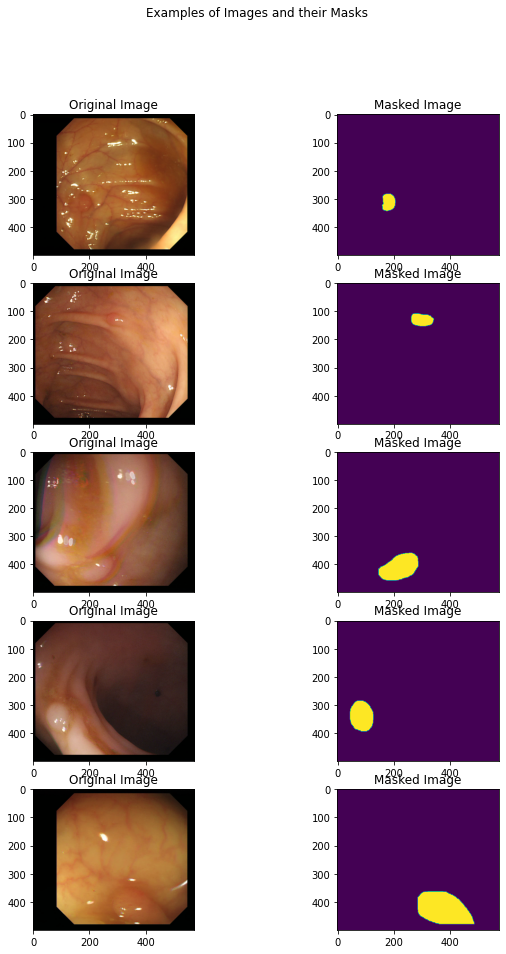

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [8]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

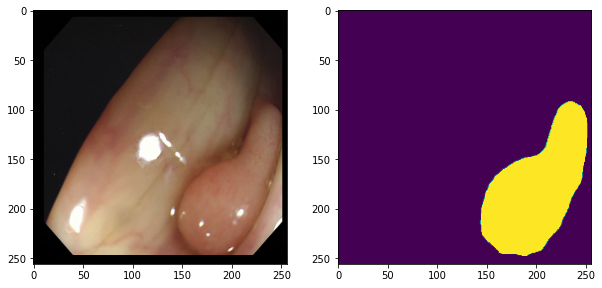

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [22]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [24]:
unet_model = UNet()

In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [26]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [28]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [29]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [30]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [31]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [32]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [33]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [34]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [35]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 36s 828ms/step - loss: 1.0176 - dice_loss: 0.7213 - val_loss: 1052.8694 - val_dice_loss: 0.9042
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 26s 828ms/step - loss: 0.9091 - dice_loss: 0.6951 - val_loss: 302.4385 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 27s 847ms/step - loss: 0.8935 - dice_loss: 0.6857 - val_loss: 793.1121 - val_dice_loss: 1.0000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 27s 857ms/step - loss: 0.9035 - dice_loss: 0.6977 - val_loss: 27.31

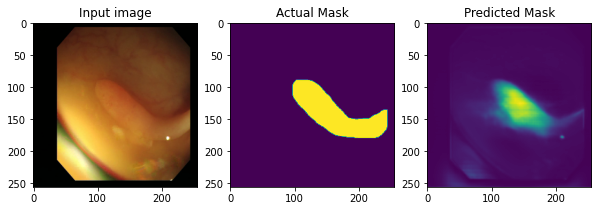

In [36]:
# print sample image after training
print_images()

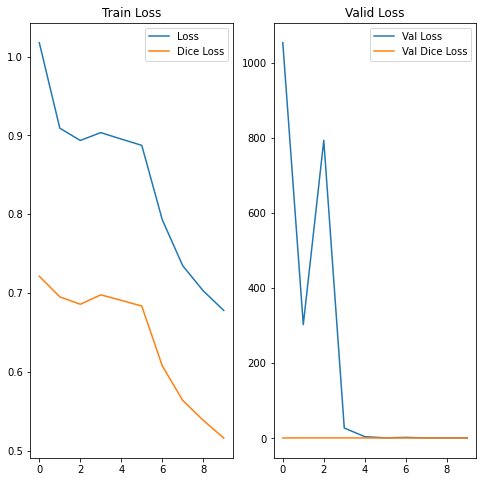

In [37]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [38]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [39]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9427873185986211


In [41]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

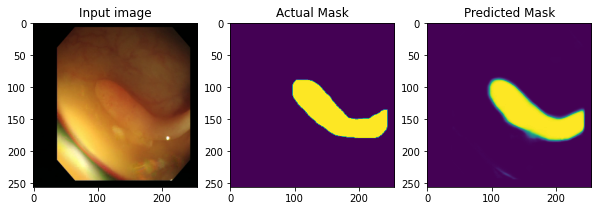

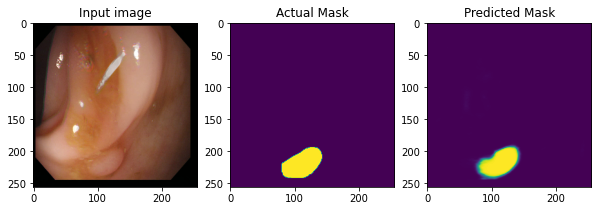

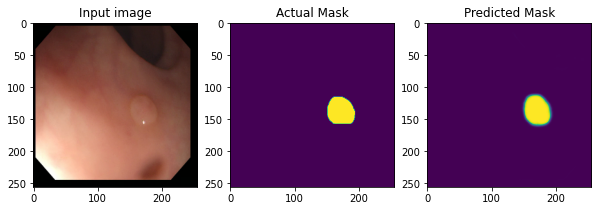

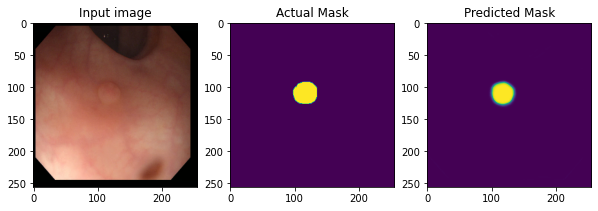

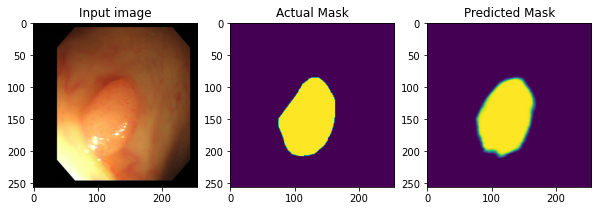

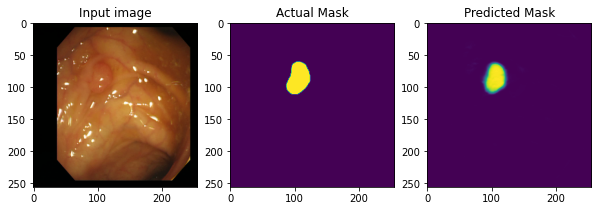

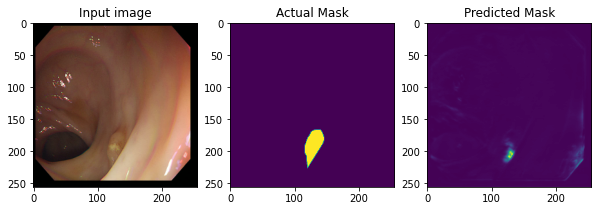

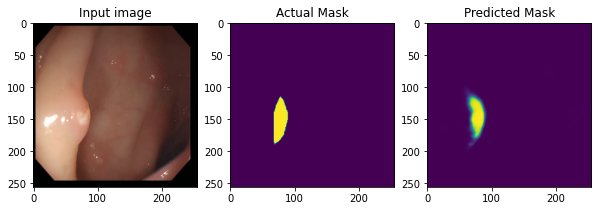

In [42]:
print_images()

In [43]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


In [44]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

58900480/58889256 [==============================] - 0s 0us/step


[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [45]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [46]:
# ==================================
# STEP 1-A: 기본 설정 및 라이브러리 임포트
# ==================================
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools # functools.partial 사용을 위해

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline # 주피터 노트북 환경에서 주석 해제
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
# from IPython.display import clear_output # 주피터 노트북 환경에서 주석 해제

import tensorflow as tf
import tensorflow_addons as tfa # 이미지 이동(translate)을 위해
import sklearn

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import applications

# Matplotlib 설정
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

# 라이브러리 버전 확인
print("# --- 주요 라이브러리 버전 확인 ---")
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Addons Version: {tfa.__version__}") # tfa 버전 추가
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Matplotlib Version: {mpl.__version__}") # mpl 버전 추가
print("# --------------------------------")

print("STEP 1-A: 라이브러리 임포트 및 기본 설정 완료.")

# --- 주요 라이브러리 버전 확인 ---
TensorFlow Version: 2.6.0
TensorFlow Addons Version: 0.14.0
Scikit-learn Version: 1.0
NumPy Version: 1.21.4
Matplotlib Version: 3.4.3
# --------------------------------
STEP 1-A: 라이브러리 임포트 및 기본 설정 완료.


In [47]:
# =================================================
# STEP 1-B: 데이터셋 경로 설정 및 파일 목록 로딩
# =================================================
# (STEP 1-A에서 임포트한 'os' 라이브러리가 필요합니다.)

# 데이터셋 경로 설정 (중요: 실제 환경에 맞게 경로를 설정해야 합니다)
try:
    # AIFFEL 환경 기준 경로
    DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')
    if not os.path.exists(os.path.join(DATASET_PATH, "train")):
         raise FileNotFoundError("Dataset not found in default AIFFEL path.")
except (TypeError, FileNotFoundError):
    # 다른 환경 (예: Colab, 로컬)의 경우 직접 경로 설정
    print("Warning: Default AIFFEL dataset path not found or accessible.")
    print("Please set DATASET_PATH manually to your dataset location.")
    # 예시: DATASET_PATH = './medical_data' # 사용자 환경에 맞게 수정하세요!
    DATASET_PATH = './medical_data' # 임시 경로 (실제 사용 시 반드시 수정!)
    if not os.path.exists(DATASET_PATH):
        os.makedirs(DATASET_PATH)
        print(f"Created placeholder directory: {DATASET_PATH}")
        print("Please download the Giana dataset and place 'train' and 'train_labels' folders inside.")

print(f"Using Dataset Path: {DATASET_PATH}")

# 이미지 및 라벨 디렉토리 정의
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

# 디렉토리 존재 여부 확인
if not os.path.isdir(img_dir):
    raise FileNotFoundError(f"Image directory not found: {img_dir}. Please ensure the dataset is correctly placed.")
if not os.path.isdir(label_dir):
    raise FileNotFoundError(f"Label directory not found: {label_dir}. Please ensure the dataset is correctly placed.")
else:
    print(f"Image directory found: {img_dir}")
    print(f"Label directory found: {label_dir}")

# 파일 목록 로드 및 정렬
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

# 로드된 파일 개수 확인
print(f"Total images found: {len(x_train_filenames)}")
print(f"Total labels found: {len(y_train_filenames)}")
if len(x_train_filenames) == 0 or len(y_train_filenames) == 0:
    raise ValueError("No images or labels found in the specified directories.")
if len(x_train_filenames) != len(y_train_filenames):
    print("Warning: Number of images and labels do not match!")


print("STEP 1-B: 데이터 경로 설정 및 파일 목록 로딩 완료.")

Using Dataset Path: /aiffel/aiffel/medical
Image directory found: /aiffel/aiffel/medical/train
Label directory found: /aiffel/aiffel/medical/train_labels
Total images found: 300
Total labels found: 300
STEP 1-B: 데이터 경로 설정 및 파일 목록 로딩 완료.


In [48]:
# ==============================================
# STEP 1-C: 데이터 분할 및 하이퍼파라미터 설정
# ==============================================
# (STEP 1-A에서 임포트한 'train_test_split'이 필요합니다.)
# (STEP 1-B에서 생성된 'x_train_filenames', 'y_train_filenames' 리스트가 필요합니다.)

# 데이터셋 분할 (훈련 80%, 검증 20%)
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames,
                                     test_size=0.2, # 20%를 검증 세트로 사용
                                     random_state=42) # 재현성을 위한 시드 고정

# 분할된 데이터 개수 확인
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print(f"훈련 데이터 개수 (Number of training examples): {num_train_examples}")
print(f"검증 데이터 개수 (Number of validation examples): {num_val_examples}")
if num_train_examples == 0 or num_val_examples == 0:
    raise ValueError("Training or validation set is empty after splitting.")

# 하이퍼파라미터 설정
image_size = 256     # 이미지 리사이즈 크기
img_shape = (image_size, image_size, 3) # 이미지 형태 (높이, 너비, 채널)
batch_size = 8      # 배치 크기 (GPU 메모리에 따라 조절)
max_epochs = 15     # 최대 학습 에포크 수 (필요시 조절)

print("\nHyperparameters:")
print(f"  Image Size: {image_size}x{image_size}")
print(f"  Batch Size: {batch_size}")
print(f"  Max Epochs: {max_epochs}")

print("\nSTEP 1-C: 데이터 분할 및 하이퍼파라미터 설정 완료.")

훈련 데이터 개수 (Number of training examples): 240
검증 데이터 개수 (Number of validation examples): 60

Hyperparameters:
  Image Size: 256x256
  Batch Size: 8
  Max Epochs: 15

STEP 1-C: 데이터 분할 및 하이퍼파라미터 설정 완료.


In [49]:
# =======================================
# STEP 1-D: 전처리 및 증강 함수 정의
# =======================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'tensorflow_addons' as tfa 가 필요합니다.)
# (STEP 1-C에서 정의된 'image_size', 'img_shape' 변수가 필요합니다.)

# --- 데이터 전처리 함수 ---
def _process_pathnames(fname, label_path):
    """이미지와 라벨 파일을 읽고 전처리하는 함수"""
    # 이미지 읽기 및 디코딩 (BMP)
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    # 라벨 읽기 및 디코딩 (BMP), 그레이스케일 변환
    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3) # 우선 3채널로 읽음
    label_img = tf.image.rgb_to_grayscale(label_img) # (h, w, 1) 형태로 변환

    # 리사이즈
    resize = [image_size, image_size]
    img = tf.image.resize(img, resize, method=tf.image.ResizeMethod.BILINEAR) # 이미지는 Bilinear
    label_img = tf.image.resize(label_img, resize, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # 라벨은 Nearest Neighbor

    # 정규화 (0~1 사이 값)
    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    # 라벨 이진화 (0 또는 1 값으로)
    label_img = tf.round(label_img)

    return img, label_img

# --- 데이터 증강 함수 (이동) ---
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """이미지와 라벨을 동일하게 수평/수직 이동시키는 함수 (tfa 사용)"""
    if width_shift_range or height_shift_range:
        # 이동 범위 랜덤하게 결정
        if width_shift_range:
            width_shift_range = tf.random.uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])

        # 이미지 이동 (Bilinear 보간)
        output_img = tfa.image.translate(output_img, [width_shift_range, height_shift_range], interpolation='bilinear')
        # 라벨 이동 (Nearest Neighbor 보간)
        label_img = tfa.image.translate(label_img, [width_shift_range, height_shift_range], interpolation='nearest')
    return output_img, label_img

# --- 데이터 증강 함수 (좌우 반전) ---
def flip_img(horizontal_flip, tr_img, label_img):
    """50% 확률로 이미지와 라벨을 좌우 반전시키는 함수"""
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        # tf.cond 사용하여 조건부 실행
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                  lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)), # True일 때 실행
                                  lambda: (tr_img, label_img)) # False일 때 실행 (원본 유지)
    return tr_img, label_img

# --- 데이터 증강 함수 (종합) ---
def _augment(img, label_img,
             hue_delta=0.1,           # 색조 변화 범위 (0은 변화 없음)
             horizontal_flip=True,    # 좌우 반전 적용 여부
             width_shift_range=0.1,   # 너비 이동 비율 (0은 이동 없음)
             height_shift_range=0.1): # 높이 이동 비율 (0은 이동 없음)
    """정의된 증강 기법들을 순차적으로 적용하는 함수"""
    # 색조 변화 (이미지에만 적용)
    if hue_delta > 0: # hue_delta가 0보다 클 때만 적용
        img = tf.image.random_hue(img, hue_delta)

    # 좌우 반전 (이미지, 라벨 모두 적용)
    img, label_img = flip_img(horizontal_flip, img, label_img)

    # 이동 (이미지, 라벨 모두 적용)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)

    # 필요시 다른 증강 기법 추가 가능 (밝기, 채도, 대비, 회전 등)
    # img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label_img

print("STEP 1-D: 전처리 및 증강 함수 정의 완료.")

STEP 1-D: 전처리 및 증강 함수 정의 완료.


훈련 데이터셋 객체: <PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>
검증 데이터셋 객체: <PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

훈련 데이터셋 샘플 시각화 (첫 번째 배치):
  Images batch shape: (8, 256, 256, 3)
  Labels batch shape: (8, 256, 256, 1)


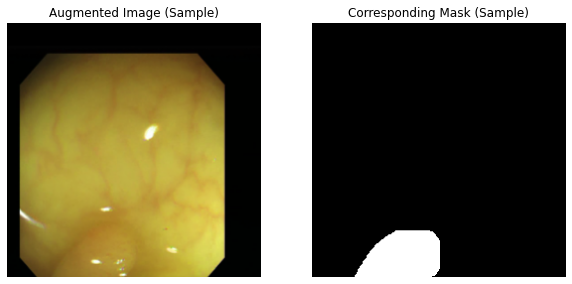


STEP 1-E: tf.data.Dataset 생성 및 시각화 완료.
# --- STEP 1 전체 완료 ---


In [50]:
# ==============================================
# STEP 1-E: tf.data.Dataset 생성 및 시각화
# ==============================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'functools' 가 필요합니다.)
# (STEP 1-C에서 정의된 'batch_size' 변수가 필요합니다.)
# (STEP 1-D에서 정의된 '_process_pathnames', '_augment' 함수가 필요합니다.)
# (STEP 1-C에서 생성된 파일 경로 리스트들('x_train_filenames' 등)이 필요합니다.)

# --- tf.data.Dataset 생성 함수 정의 ---
def get_baseline_dataset(filenames,       # 이미지 파일 경로 리스트
                         labels,          # 라벨 파일 경로 리스트
                         preproc_fn=functools.partial(_augment), # 사용할 증강 함수 (기본값: _augment)
                         threads=tf.data.AUTOTUNE, # 병렬 처리 스레드 수 (자동 설정)
                         batch_size=batch_size,    # 배치 크기
                         shuffle_buffer_size=1000, # 셔플 버퍼 크기 (훈련 시 사용)
                         is_train=True):           # 훈련용 데이터셋 여부
    """파일 경로 리스트로부터 tf.data.Dataset 객체를 생성하는 함수"""
    num_x = len(filenames)
    # 1. 파일 경로 리스트로부터 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # 2. 전처리 함수(_process_pathnames) 매핑 (병렬 처리)
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    # 3. 훈련용 데이터셋인 경우, 셔플링 및 증강 적용
    if is_train:
        # 데이터 셔플링
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
        # 증강 함수(preproc_fn) 매핑 (병렬 처리)
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    # 4. 배치 단위로 묶기
    dataset = dataset.batch(batch_size)

    # 5. 데이터 로딩 최적화를 위해 prefetch 적용
    # 학습 중 GPU가 연산하는 동안 CPU가 다음 배치를 미리 준비하도록 함
    dataset = dataset.prefetch(buffer_size=threads)

    return dataset

# --- 훈련 및 검증 데이터셋 생성 ---
# 훈련 데이터셋 (셔플링 및 증강 적용)
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames, is_train=True)
# 검증 데이터셋 (셔플링 및 증강 미적용)
val_dataset = get_baseline_dataset(x_val_filenames, y_val_filenames, is_train=False)

print("훈련 데이터셋 객체:", train_dataset)
print("검증 데이터셋 객체:", val_dataset)

# --- 생성된 데이터셋의 샘플 시각화 ---
print("\n훈련 데이터셋 샘플 시각화 (첫 번째 배치):")
for images, labels in train_dataset.take(1): # take(1)로 첫 번째 배치만 가져옴
    print(f"  Images batch shape: {images.shape}") # 이미지 배치 형태 출력
    print(f"  Labels batch shape: {labels.shape}") # 라벨 배치 형태 출력

    plt.figure(figsize=(10, 5)) # 시각화 figure 크기 조정
    # 배치 중 첫 번째 이미지와 라벨 선택
    img_to_show = images[0]
    label_to_show = labels[0]

    # 이미지 표시
    plt.subplot(1, 2, 1)
    plt.imshow(img_to_show)
    plt.title("Augmented Image (Sample)")
    plt.axis('off') # 축 정보 숨기기

    # 라벨(마스크) 표시 (그레이스케일)
    plt.subplot(1, 2, 2)
    plt.imshow(label_to_show[:, :, 0], cmap='gray') # 라벨은 채널 0을 그레이스케일로 표시
    plt.title("Corresponding Mask (Sample)")
    plt.axis('off')

    plt.show()
    break # 한 배치만 시각화하고 종료

print("\nSTEP 1-E: tf.data.Dataset 생성 및 시각화 완료.")
print("# --- STEP 1 전체 완료 ---")

In [51]:
# =================================================
# STEP 2-A: U-Net 구성 요소 (헬퍼 클래스) 정의
# =================================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf 와 'layers'가 필요합니다.)

# --- 기본 Convolution 블록 정의 ---
class Conv(tf.keras.Model):
    """Conv - BatchNorm - ReLU 블록"""
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        # He 초기화를 사용하여 가중치 초기화
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU() # ReLU 활성화 함수를 별도 레이어로 사용

    def call(self, inputs, training=True):
        # training=True/False에 따라 BatchNorm 동작이 달라짐
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        return x

# --- 두 개의 Conv 블록 (주로 인코더/센터용) ---
class ConvBlock(tf.keras.Model):
    """두 개의 Conv 블록으로 구성 (U-Net 논문 스타일)"""
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3) # 3x3 커널 사용
        self.conv2 = Conv(num_filters, 3) # 필터 수 유지

    def call(self, inputs, training=True):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        return x

# --- 두 개의 Conv 블록 (주로 디코더용) ---
class ConvBlock_R(tf.keras.Model):
    """두 개의 Conv 블록으로 구성 (디코더에서 사용)"""
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        return x

# --- 디코더 블록 정의 ---
class DecoderBlock(tf.keras.Model):
    """Upsampling(ConvTranspose) - Concatenate - ConvBlock_R 로 구성된 디코더 블록"""
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        # Upsampling: 필터 수를 조절하며 해상도 2배 증가 (Transposed Convolution)
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()
        # Upsampling 후 적용될 Convolution 블록
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        # 1. Upsampling (Transposed Convolution)
        x = self.convT(input_tensor)
        # 2. BatchNorm & Activation
        x = self.bn(x, training=training)
        x = self.relu(x)
        # 3. Skip connection과 결합 (채널 축 기준)
        x = tf.concat([x, concat_tensor], axis=-1)
        # 4. Conv 블록 통과
        x = self.conv_block_r(x, training=training)
        return x

print("STEP 2-A: U-Net 구성 요소 (헬퍼 클래스) 정의 완료.")

STEP 2-A: U-Net 구성 요소 (헬퍼 클래스) 정의 완료.


In [52]:
# =====================================
# STEP 2-B: VGG16 U-Net 클래스 정의
# =====================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'models', 'layers', 'applications'가 필요합니다.)
# (STEP 1-C에서 정의된 'img_shape' 변수가 필요합니다.)
# (STEP 2-A에서 정의된 'DecoderBlock' 클래스가 필요합니다.)

class Vgg16UNet(tf.keras.Model):
    """VGG16을 인코더로 사용하는 U-Net 모델"""
    def __init__(self, num_classes=1): # 분할할 클래스 수 (배경 포함, 여기서는 1개)
        super(Vgg16UNet, self).__init__()
        self.num_classes = num_classes

        # --- 1. Pretrained VGG16 인코더 로드 ---
        # include_top=False: VGG16의 마지막 분류 레이어 제외
        # weights='imagenet': ImageNet으로 사전 학습된 가중치 사용
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                                 include_top=False,
                                                 weights='imagenet')

        # --- 2. Skip Connection을 위한 VGG16 중간 레이어 지정 ---
        # U-Net의 Skip Connection에 해당하는 VGG16 블록의 마지막 Convolution 레이어 선택
        layer_names = [
            'block1_conv2', # 64 filters, 256x256 -> decoder_block1으로 연결
            'block2_conv2', # 128 filters, 128x128 -> decoder_block2로 연결
            'block3_conv3', # 256 filters, 64x64 -> decoder_block3으로 연결
            'block4_conv3', # 512 filters, 32x32 -> decoder_block4로 연결
            'block5_conv3'  # 512 filters, 16x16 -> Bottleneck(Center) 입력
        ]
        # 지정된 이름의 레이어 객체로부터 출력 텐서를 가져옴
        layer_outputs = [self.vgg16.get_layer(name).output for name in layer_names]

        # --- 3. Skip Connection 출력을 제공하는 새로운 모델 생성 ---
        # VGG16의 입력을 받아 지정된 중간 레이어들의 출력을 반환하는 모델
        self.vgg16_act = models.Model(inputs=self.vgg16.input,
                                      outputs=layer_outputs,
                                      name='vgg16_encoder_outputs')

        # --- 4. VGG16 인코더 레이어 동결 (Transfer Learning) ---
        # 사전 학습된 가중치가 학습 중에 업데이트되지 않도록 설정
        self.vgg16_act.trainable = False
        print(f"VGG16 Encoder Trainable: {self.vgg16_act.trainable}")

        # --- 5. U-Net의 Center (Bottleneck) ---
        # VGG16의 마지막 출력('block5_conv3')을 그대로 사용하거나,
        # 필요시 여기에 추가적인 ConvBlock을 적용할 수 있습니다.
        # 예: self.center = ConvBlock(1024) # 필요하다면 주석 해제

        # --- 6. U-Net 디코더 블록 정의 ---
        # DecoderBlock은 Upsampling 후 Skip Connection과 Concatenate되므로,
        # 각 블록의 필터 수는 해당 단계의 Skip Connection 채널 수와 맞추거나 조절합니다.
        # DecoderBlock(N): ConvTranspose 필터 수를 N개로 설정
        self.decoder_block4 = DecoderBlock(512) # Input: center(512), Skip: enc4(512)
        self.decoder_block3 = DecoderBlock(256) # Input: dec4(512), Skip: enc3(256)
        self.decoder_block2 = DecoderBlock(128) # Input: dec3(256), Skip: enc2(128)
        self.decoder_block1 = DecoderBlock(64)  # Input: dec2(128), Skip: enc1(64)

        # --- 7. 최종 출력 레이어 ---
        # 1x1 Convolution을 사용하여 최종 마스크 생성 (클래스 수만큼의 채널)
        # Sigmoid 활성화 함수: 픽셀별 이진 분류 (0~1 확률)
        self.output_conv = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='final_output')

    # --- 모델의 Forward Pass 정의 ---
    def call(self, inputs, training=True):
        # 1. VGG16 인코더 통과 (Skip Connection 출력 얻기)
        # VGG16 내부의 BatchNorm 레이어 때문에 'training' 인자 전달이 중요
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs, training=training)

        # Optional: Center ConvBlock 적용 (만약 정의했다면)
        # if hasattr(self, 'center'):
        #    center = self.center(center, training=training)

        # 2. 디코더 및 Skip Connection 연결
        # 각 디코더 블록에 이전 블록의 출력과 해당 레벨의 인코더 출력을 전달
        decoder4 = self.decoder_block4(center, encoder4, training=training)
        decoder3 = self.decoder_block3(decoder4, encoder3, training=training)
        decoder2 = self.decoder_block2(decoder3, encoder2, training=training)
        decoder1 = self.decoder_block1(decoder2, encoder1, training=training)

        # 3. 최종 출력 생성
        outputs = self.output_conv(decoder1)

        return outputs

print("STEP 2-B: VGG16 U-Net 클래스 정의 완료.")

STEP 2-B: VGG16 U-Net 클래스 정의 완료.


In [53]:
# ============================================================
# STEP 2-C: VGG16 U-Net 모델 인스턴스 생성 및 구조 확인
# ============================================================
# (STEP 1-C에서 정의된 'image_size', 'img_shape' 변수가 필요합니다.)
# (STEP 2-B에서 정의된 'Vgg16UNet' 클래스가 필요합니다.)

# --- Vgg16UNet 모델 인스턴스 생성 ---
# num_classes=1 : 배경과 객체 하나를 분할하는 이진 분할
vgg16_unet_model = Vgg16UNet(num_classes=1)

# --- 모델 구조 확인 (Build & Summary) ---
# 모델의 레이어를 실제로 생성하기 위해 build 메서드를 호출하거나
# 더미 데이터로 한번 호출하여 레이어를 빌드합니다.
# input_shape: (배치크기=None, 높이, 너비, 채널)
vgg16_unet_model.build(input_shape=(None, image_size, image_size, 3))

# 모델 요약 정보 출력 (레이어 구성, 출력 형태, 파라미터 수 등)
print("\n--- VGG16 U-Net Model Summary ---")
vgg16_unet_model.summary()
print("---------------------------------")

print("\nSTEP 2-C: VGG16 U-Net 모델 인스턴스 생성 및 구조 확인 완료.")
print("# --- STEP 2 전체 완료 ---")

VGG16 Encoder Trainable: False

--- VGG16 U-Net Model Summary ---
Model: "vgg16u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
vgg16_encoder_outputs (Funct [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
decoder_block_4 (DecoderBloc multiple                  9444864   
_________________________________________________________________
decoder_block_5 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_6 (DecoderBloc multiple                  739200    
_________________________________________________________________
decoder_block_7 (DecoderBloc multiple                  185280    
________________________________________________________

In [54]:
# ========================================================
# STEP 3-A: 손실 함수 및 평가지표(Mean IoU) 함수 정의
# ========================================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'numpy' as np, 'losses', 'confusion_matrix'가 필요합니다.)

# --- Dice Coefficient 함수 ---
def dice_coeff(y_true, y_pred):
    """Dice Coefficient 계산 함수"""
    smooth = 1e-10 # 분모 0 방지용 작은 값
    y_true_f = tf.reshape(y_true, [-1]) # 1차원으로 평탄화
    y_pred_f = tf.reshape(y_pred, [-1]) # 1차원으로 평탄화
    intersection = tf.reduce_sum(y_true_f * y_pred_f) # 교집합 계산
    # Dice 계수 계산: 2 * |A∩B| / (|A| + |B|)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

# --- Dice Loss 함수 ---
def dice_loss(y_true, y_pred):
    """Dice Loss 계산 함수 (1 - Dice Coefficient)"""
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

# --- Binary Cross Entropy + Dice Loss 결합 함수 ---
def bce_dice_loss(y_true, y_pred):
    """BCE와 Dice Loss를 결합한 손실 함수"""
    # Binary Cross Entropy 계산
    bce = losses.binary_crossentropy(y_true, y_pred)
    # Dice Loss 계산 (타입 일치 필요)
    y_true_float = tf.cast(y_true, tf.float32)
    d_loss = dice_loss(y_true_float, y_pred)
    # 배치 내 각 샘플의 BCE 평균값 + Dice Loss
    loss = tf.reduce_mean(bce) + d_loss
    return loss

# --- Mean IoU 계산 함수 ---
def mean_iou(y_true, y_pred, num_classes=2):
    """Mean Intersection over Union (mIoU) 계산 함수"""
    # 1차원으로 평탄화
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # 예측값을 0 또는 1로 변환 (Sigmoid 출력 기준 0.5 임계값)
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32)
    # 실제 라벨도 0 또는 1의 정수형으로 변환 (이미 되어있어야 하지만 확인 차원)
    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32)

    # TensorFlow 텐서를 NumPy 배열로 변환 (confusion_matrix 입력용)
    y_true_np = y_true_f.numpy()
    y_pred_np = y_pred_f.numpy()

    # 혼동 행렬(Confusion Matrix) 계산
    # labels: 계산할 클래스 목록 (여기서는 0: 배경, 1: 객체)
    labels = list(range(num_classes))
    conf_matrix = confusion_matrix(y_true_np, y_pred_np, labels=labels)

    # IoU 계산
    intersection = np.diag(conf_matrix) # 대각 원소 = 각 클래스의 True Positive (TP)
    ground_truth_set = conf_matrix.sum(axis=1) # 행 합계 = 각 클래스의 실제 샘플 수 (TP + FN)
    predicted_set = conf_matrix.sum(axis=0) # 열 합계 = 각 클래스의 예측 샘플 수 (TP + FP)
    union = ground_truth_set + predicted_set - intersection # 합집합 = TP + FN + FP

    # 0으로 나누는 경우 방지하며 IoU 계산 (Intersection / Union)
    # union이 0인 경우(해당 클래스가 없거나 예측되지 않음) 결과는 0으로 설정
    iou = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=np.float32), where=union!=0)

    # NaN 값 0으로 처리 (np.divide에서 where 조건 만족 못해도 발생 가능성 낮음)
    iou = np.nan_to_num(iou)

    # 모든 클래스(배경 포함)의 IoU 평균 반환
    return np.mean(iou)

print("STEP 3-A: 손실 함수 및 평가지표(Mean IoU) 함수 정의 완료.")

STEP 3-A: 손실 함수 및 평가지표(Mean IoU) 함수 정의 완료.


In [55]:
# ===========================================
# STEP 3-B: 옵티마이저 정의 및 모델 컴파일
# ===========================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf가 필요합니다.)
# (STEP 2-C에서 생성된 'vgg16_unet_model' 객체가 필요합니다.)
# (STEP 3-A에서 정의된 'bce_dice_loss', 'dice_loss' 함수가 필요합니다.)

# --- 옵티마이저 정의 ---
# Adam 옵티마이저 사용 (학습률은 스케줄러로 별도 관리 예정)
optimizer = tf.keras.optimizers.Adam()
print(f"Optimizer: {type(optimizer).__name__}")

# --- 모델 컴파일 ---
# 모델에 옵티마이저, 손실 함수, 평가 지표를 설정
vgg16_unet_model.compile(optimizer=optimizer,                # 사용할 옵티마이저
                         loss=bce_dice_loss,               # 주 손실 함수
                         metrics=[dice_loss,               # 추가 평가 지표 1: Dice Loss
                                  'binary_accuracy'])     # 추가 평가 지표 2: 정확도

print("VGG16 U-Net 모델 컴파일 완료.")
print(f"  Loss function: {bce_dice_loss.__name__}")
print(f"  Metrics: {[dice_loss.__name__, 'binary_accuracy']}")

print("\nSTEP 3-B: 옵티마이저 정의 및 모델 컴파일 완료.")

Optimizer: Adam
VGG16 U-Net 모델 컴파일 완료.
  Loss function: bce_dice_loss
  Metrics: ['dice_loss', 'binary_accuracy']

STEP 3-B: 옵티마이저 정의 및 모델 컴파일 완료.


In [56]:
# ================================
# STEP 3-C: 콜백(Callbacks) 설정
# ================================
# (STEP 1-A에서 임포트한 'os', 'tensorflow' as tf가 필요합니다.)
# (STEP 1-B에서 정의된 'DATASET_PATH' 변수가 필요합니다.)
# (STEP 1-C에서 정의된 'max_epochs', 'num_train_examples', 'batch_size' 변수가 필요합니다.)

# --- 체크포인트(Checkpoint) 콜백 설정 ---
# 모델 가중치를 저장할 디렉토리 경로 정의
checkpoint_dir_vgg = os.path.join(DATASET_PATH, 'train_ckpt/vgg16_unet_model')

# 디렉토리가 없으면 생성
if not os.path.isdir(checkpoint_dir_vgg):
    os.makedirs(checkpoint_dir_vgg)
    print(f"Created checkpoint directory: {checkpoint_dir_vgg}")

# ModelCheckpoint 콜백 정의
cp_callback_vgg = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_vgg, 'ckpt-{epoch:02d}-{val_loss:.4f}'), # 저장될 파일 이름 형식
    save_weights_only=True,  # 모델 전체가 아닌 가중치만 저장
    monitor='val_loss',      # 모니터링할 지표 (검증 손실)
    mode='min',              # 모니터링 지표를 최소화하는 방향으로 저장 (loss이므로 min)
    save_best_only=True,     # 가장 좋은 성능의 모델만 저장
    verbose=1                # 저장 시 로그 출력
)
print("ModelCheckpoint callback configured.")
print(f"  Weights will be saved to: {checkpoint_dir_vgg}")

# --- 학습률 스케줄러(Learning Rate Scheduler) 콜백 설정 ---
# 초기 학습률 설정 (Pretrained 모델 사용 시 일반적으로 낮게 설정)
initial_learning_rate = 1e-4

# 총 학습 스텝 수 계산 (전체 에포크 * 에포크당 스텝 수)
steps_per_epoch = num_train_examples // batch_size
if steps_per_epoch == 0: # 데이터가 매우 적어 steps_per_epoch가 0이 되는 경우 방지
    steps_per_epoch = 1
total_decay_steps = max_epochs * steps_per_epoch

# Cosine Decay 학습률 스케줄 정의
cos_decay = tf.keras.experimental.CosineDecay(
    initial_learning_rate=initial_learning_rate, # 시작 학습률
    decay_steps=total_decay_steps                # 학습률이 0에 도달할 때까지의 스텝 수
)
print(f"CosineDecay learning rate schedule configured.")
print(f"  Initial learning rate: {initial_learning_rate}")
print(f"  Total decay steps: {total_decay_steps}")

# LearningRateScheduler 콜백 정의
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1) # 에포크 시작 시 학습률 출력

print("\nSTEP 3-C: 콜백(Callbacks) 설정 완료.")

Created checkpoint directory: /aiffel/aiffel/medical/train_ckpt/vgg16_unet_model
ModelCheckpoint callback configured.
  Weights will be saved to: /aiffel/aiffel/medical/train_ckpt/vgg16_unet_model
CosineDecay learning rate schedule configured.
  Initial learning rate: 0.0001
  Total decay steps: 450

STEP 3-C: 콜백(Callbacks) 설정 완료.


In [57]:
# =========================
# STEP 3-D: 모델 학습 실행
# =========================
# (STEP 1-E에서 생성된 'train_dataset', 'val_dataset'이 필요합니다.)
# (STEP 1-C에서 정의된 'max_epochs', 'num_train_examples', 'num_val_examples', 'batch_size' 변수가 필요합니다.)
# (STEP 2-C에서 생성된 'vgg16_unet_model' 객체가 필요합니다.)
# (STEP 3-C에서 정의된 'cp_callback_vgg', 'lr_callback' 콜백이 필요합니다.)

print("\n--- VGG16 U-Net 모델 학습 시작 ---")

# 에포크당 스텝 수 및 검증 스텝 수 계산 (0 방지)
steps_per_epoch = num_train_examples // batch_size
if steps_per_epoch == 0: steps_per_epoch = 1

validation_steps = num_val_examples // batch_size
if validation_steps == 0: validation_steps = 1

print(f"Training parameters:")
print(f"  Epochs: {max_epochs}")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Validation steps per epoch: {validation_steps}")

# model.fit() 함수를 사용하여 모델 학습 시작
history_vgg = vgg16_unet_model.fit(
    train_dataset,                      # 훈련 데이터셋
    epochs=max_epochs,                  # 총 학습 에포크 수
    steps_per_epoch=steps_per_epoch,    # 에포크당 훈련 스텝 수
    validation_data=val_dataset,        # 검증 데이터셋
    validation_steps=validation_steps,  # 에포크당 검증 스텝 수
    callbacks=[cp_callback_vgg,         # 체크포인트 콜백
               lr_callback]             # 학습률 스케줄러 콜백
)

print("\n--- VGG16 U-Net 모델 학습 완료 ---")
print("STEP 3-D: 모델 학습 실행 완료.")


--- VGG16 U-Net 모델 학습 시작 ---
Training parameters:
  Epochs: 15
  Steps per epoch: 30
  Validation steps per epoch: 7
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(1e-04, shape=(), dtype=float32).
30/30 [==============================] - 22s 458ms/step - loss: 1.2418 - dice_loss: 0.8765 - binary_accuracy: 0.9048 - val_loss: 1.2860 - val_dice_loss: 0.8883 - val_binary_accuracy: 0.8724

Epoch 00001: val_loss improved from inf to 1.28601, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_unet_model/ckpt-01-1.2860
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(9.999878e-05, shape=(), dtype=float32).
30/30 [==============================] - 14s 450ms/step - loss: 1.0125 - dice_loss: 0.7521 - binary_accuracy: 0.9334 - val_loss: 1.8271 - val_dice_loss: 0.8541 - val_binary_accuracy: 0.4791

Epoch 00002: val_loss did not improve from 1.28601
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to tf.Ten


--- 학습 과정 시각화 ---


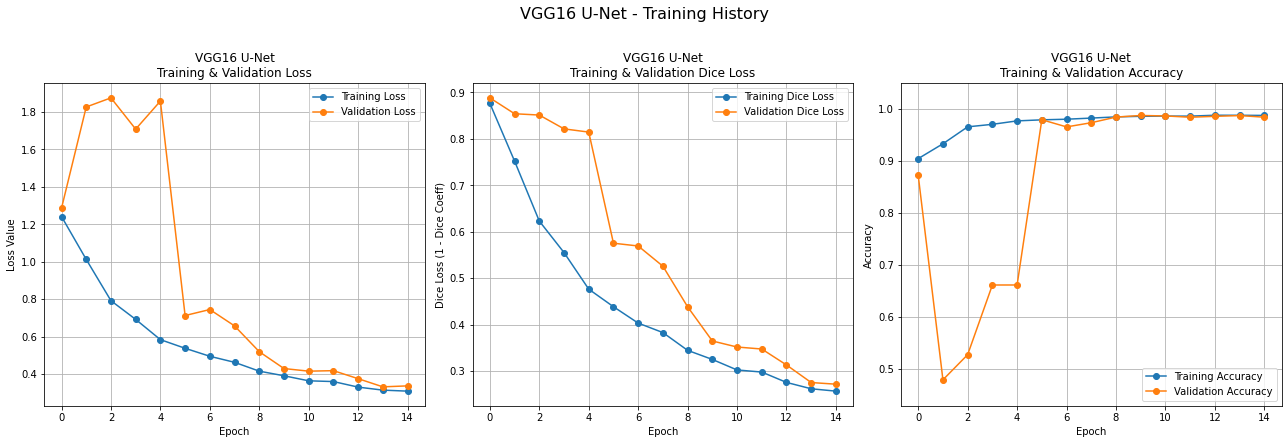


STEP 3-E: 학습 과정 시각화 완료.


In [58]:
# ==============================
# STEP 3-E: 학습 과정 시각화
# ==============================
# (STEP 1-A에서 임포트한 'matplotlib.pyplot' as plt가 필요합니다.)
# (STEP 3-D에서 반환된 'history_vgg' 객체가 필요합니다.)

print("\n--- 학습 과정 시각화 ---")

# --- 학습 결과 시각화 함수 정의 ---
def plot_training_history(history, model_name):
    """학습 과정의 손실 및 평가지표 시각화 함수"""
    # history 객체에서 지표 값 추출
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    dice = history.history.get('dice_loss') # 컴파일 시 metrics에 추가한 이름
    val_dice = history.history.get('val_dice_loss')
    accuracy = history.history.get('binary_accuracy') # 컴파일 시 metrics에 추가한 이름
    val_accuracy = history.history.get('val_binary_accuracy')

    if loss is None:
      print("Error: 'loss' not found in history object. Training might have failed.")
      return

    epochs_range = range(len(loss)) # 실제 학습한 에포크 수

    plt.figure(figsize=(18, 6)) # figure 크기 설정 (가로 넓게)

    # 첫 번째 subplot: Training & Validation Loss (BCE + Dice)
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, loss, 'o-', label='Training Loss') # 마커와 선 함께 표시
    plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss')
    plt.legend(loc='best') # 범례 최적 위치에 표시
    plt.title(f'{model_name}\nTraining & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.grid(True) # 그리드 표시

    # 두 번째 subplot: Training & Validation Dice Loss
    if dice and val_dice: # Dice Loss 지표가 history에 있을 경우
        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, dice, 'o-', label='Training Dice Loss')
        plt.plot(epochs_range, val_dice, 'o-', label='Validation Dice Loss')
        plt.legend(loc='best')
        plt.title(f'{model_name}\nTraining & Validation Dice Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Loss (1 - Dice Coeff)')
        plt.grid(True)
    else:
        # Dice Loss 지표가 없는 경우 메시지 출력
        print("Dice loss metrics not found in history, skipping Dice Loss plot.")
        # 빈 subplot을 만들어 레이아웃 유지 (선택 사항)
        ax = plt.subplot(1, 3, 2)
        ax.text(0.5, 0.5, 'Dice Loss Plot Unavailable', horizontalalignment='center', verticalalignment='center')
        ax.set_title(f'{model_name}\nDice Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Dice Loss')
        ax.grid(True)


    # 세 번째 subplot: Training & Validation Accuracy
    if accuracy and val_accuracy: # Accuracy 지표가 history에 있을 경우
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, accuracy, 'o-', label='Training Accuracy')
        plt.plot(epochs_range, val_accuracy, 'o-', label='Validation Accuracy')
        plt.legend(loc='best')
        plt.title(f'{model_name}\nTraining & Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([min(min(accuracy), min(val_accuracy), 0.5) - 0.05, 1.05]) # y축 범위 조정 (0.5~1.05)
        plt.grid(True)
    else:
        # Accuracy 지표가 없는 경우 메시지 출력
        print("Accuracy metrics not found in history, skipping Accuracy plot.")
        ax = plt.subplot(1, 3, 3)
        ax.text(0.5, 0.5, 'Accuracy Plot Unavailable', horizontalalignment='center', verticalalignment='center')
        ax.set_title(f'{model_name}\nAccuracy')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.grid(True)


    plt.suptitle(f'{model_name} - Training History', fontsize=16, y=1.02) # 전체 제목 및 위치 조정
    plt.tight_layout() # 서브플롯 간 간격 자동 조절
    plt.show()

# --- 학습 결과 시각화 함수 호출 ---
plot_training_history(history_vgg, "VGG16 U-Net")

print("\nSTEP 3-E: 학습 과정 시각화 완료.")

In [59]:
# =====================================================
# STEP 3-F: 최적 가중치 로드 및 성능 평가 (Mean IoU)
# =====================================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'numpy' as np가 필요합니다.)
# (STEP 1-E에서 생성된 'val_dataset'이 필요합니다.)
# (STEP 2-C에서 생성된 'vgg16_unet_model' 객체가 필요합니다.)
# (STEP 3-A에서 정의된 'mean_iou' 함수가 필요합니다.)
# (STEP 3-C에서 정의된 'checkpoint_dir_vgg' 변수가 필요합니다.)

print("\n--- 최적 가중치 로드 및 Mean IoU 평가 ---")

# --- 최적 가중치 로드 ---
# ModelCheckpoint가 저장한 가장 마지막(최신) 체크포인트 파일 경로 찾기
latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir_vgg)

if latest_ckpt:
    print(f"Loading best weights from: {latest_ckpt}")
    # 모델에 최적 가중치 로드
    vgg16_unet_model.load_weights(latest_ckpt)
    print("Weights loaded successfully.")
else:
    # 체크포인트 파일이 없는 경우 경고 메시지 출력
    print("Warning: Could not find checkpoint file.")
    print("Evaluation will use weights from the end of training (if available).")

# --- 검증 데이터셋으로 Mean IoU 평가 ---
print("Calculating Mean IoU on the validation set...")
mean_iou_list = [] # 각 배치별 mIoU를 저장할 리스트

# 검증 데이터셋을 배치 단위로 순회
for images, labels in val_dataset:
    # 모델 예측 (Inference 모드: training=False)
    predictions = vgg16_unet_model(images, training=False)
    # 현재 배치에 대한 mIoU 계산
    batch_miou = mean_iou(labels, predictions)
    mean_iou_list.append(batch_miou)
    # 진행 상황 표시 (선택 사항)
    # print(f"  Batch IoU: {batch_miou:.4f}")

# 전체 검증 데이터셋에 대한 평균 mIoU 계산
# 리스트가 비어있는 경우(데이터셋이 작거나 오류 발생) 대비
if mean_iou_list:
    overall_miou = np.mean(mean_iou_list)
    print(f"\nValidation Mean IoU (VGG16 U-Net): {overall_miou:.4f}")
else:
    overall_miou = 0.0 # 또는 np.nan
    print("\nWarning: Mean IoU could not be calculated (empty result list).")


print("\nSTEP 3-F: 최적 가중치 로드 및 성능 평가 완료.")


--- 최적 가중치 로드 및 Mean IoU 평가 ---
Loading best weights from: /aiffel/aiffel/medical/train_ckpt/vgg16_unet_model/ckpt-14-0.3315
Weights loaded successfully.
Calculating Mean IoU on the validation set...

Validation Mean IoU (VGG16 U-Net): 0.8513

STEP 3-F: 최적 가중치 로드 및 성능 평가 완료.



--- 예측 결과 시각화 ---
Visualizing VGG16 U-Net predictions on validation set samples...


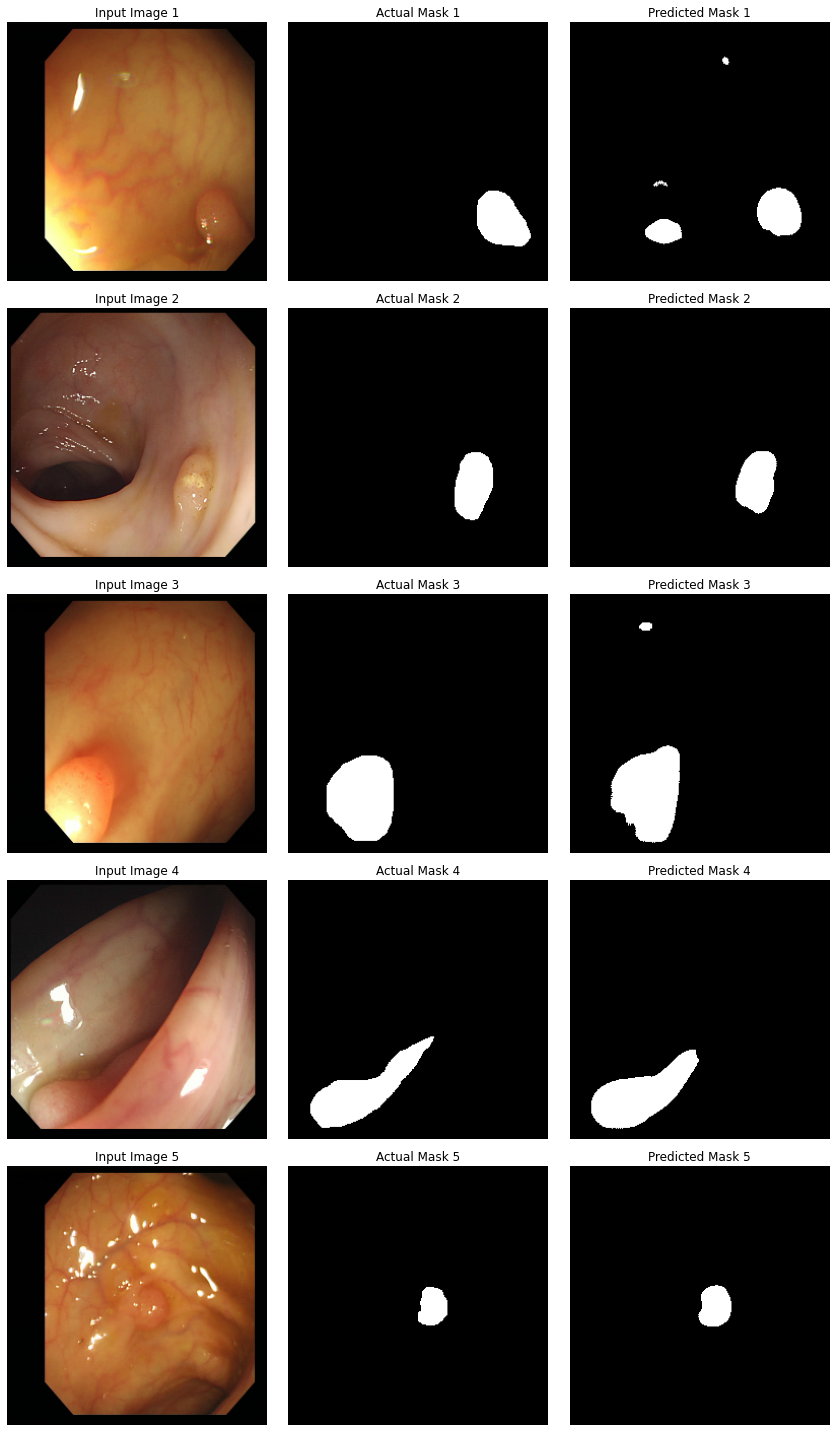


STEP 3-G: 예측 결과 시각화 완료.
# --- STEP 3 전체 완료 ---


In [60]:
# ==============================
# STEP 3-G: 예측 결과 시각화
# ==============================
# (STEP 1-A에서 임포트한 'matplotlib.pyplot' as plt가 필요합니다.)
# (STEP 1-E에서 생성된 'val_dataset'이 필요합니다.)
# (STEP 2-C에서 생성된 'vgg16_unet_model' 객체가 필요합니다. 가중치가 로드된 상태여야 함)
# (STEP 1-C에서 정의된 'batch_size' 변수가 필요합니다.)

print("\n--- 예측 결과 시각화 ---")

# --- 예측 결과 시각화 함수 정의 ---
def print_images(dataset, model, num_images=5):
    """데이터셋의 이미지, 실제 마스크, 모델 예측 마스크를 시각화하는 함수"""
    plt.figure(figsize=(12, num_images * 4)) # 전체 Figure 크기 설정
    plot_count = 0 # 표시된 이미지 수 카운터

    # 데이터셋에서 필요한 만큼의 배치를 가져옴
    # num_images가 batch_size보다 크거나 같은 경우 여러 배치가 필요할 수 있음
    for batch_idx, (test_images, test_labels) in enumerate(dataset.take(num_images // batch_size + 1)):
        if plot_count >= num_images: break # 원하는 수의 이미지를 모두 표시했으면 종료

        # 모델 예측 (배치 단위)
        predictions = model(test_images, training=False) # Inference 모드

        # 현재 배치 내의 각 이미지에 대해 처리
        for i in range(len(test_images)):
            if plot_count >= num_images: break # 원하는 수의 이미지를 모두 표시했으면 종료

            # 현재 이미지, 라벨, 예측 결과 선택
            img = test_images[i]
            label = test_labels[i]
            pred = predictions[i]

            # Subplot 1: 원본 이미지
            plt.subplot(num_images, 3, plot_count * 3 + 1)
            plt.imshow(img)
            plt.title(f"Input Image {plot_count+1}")
            plt.axis('off')

            # Subplot 2: 실제 마스크 (Ground Truth)
            plt.subplot(num_images, 3, plot_count * 3 + 2)
            plt.imshow(label[:, :, 0], cmap='gray') # 라벨은 채널 0, 그레이스케일
            plt.title(f"Actual Mask {plot_count+1}")
            plt.axis('off')

            # Subplot 3: 예측 마스크
            # 예측 결과(0~1 확률)를 0.5 임계값으로 이진화하여 표시
            plt.subplot(num_images, 3, plot_count * 3 + 3)
            plt.imshow(pred[:, :, 0] > 0.5, cmap='gray') # 0.5 초과 시 True(흰색), 아니면 False(검은색)
            plt.title(f"Predicted Mask {plot_count+1}")
            plt.axis('off')

            plot_count += 1 # 표시된 이미지 수 증가

    plt.tight_layout() # 서브플롯 간 간격 조절
    plt.show()

# --- 예측 결과 시각화 함수 호출 ---
# 검증 데이터셋(val_dataset)과 학습/로드된 모델(vgg16_unet_model) 사용
print("Visualizing VGG16 U-Net predictions on validation set samples...")
print_images(val_dataset, vgg16_unet_model, num_images=5) # 5개의 샘플 시각화

print("\nSTEP 3-G: 예측 결과 시각화 완료.")
print("# --- STEP 3 전체 완료 ---")

In [61]:
# =====================================================
# STEP 4-A: 비교 대상 모델 성능 지표 준비 (Mean IoU)
# =====================================================
# (STEP 3-F에서 계산된 VGG16 U-Net의 'overall_miou' 변수가 필요합니다.)

print("\n# --- STEP 4-A: 비교 대상 모델 성능 지표 준비 ---")

# VGG16 U-Net 모델의 Mean IoU 값 (STEP 3-F에서 계산됨)
try:
    vgg16_unet_miou = overall_miou
    print(f"VGG16 U-Net Mean IoU: {vgg16_unet_miou:.4f}")
except NameError:
    print("Warning: 'overall_miou' not found. Please ensure STEP 3-F executed correctly.")
    print("Setting VGG16 U-Net mIoU to NaN for now.")
    vgg16_unet_miou = np.nan # 오류 방지를 위해 NaN으로 설정

# --- 다른 모델들의 Mean IoU 값 (!!! 중요: 실제 값으로 수정 필요 !!!) ---
# 이 값들은 Simple Encoder-Decoder 모델과 Standard U-Net 모델을
# 동일한 데이터셋 및 조건으로 학습/평가하여 얻은 실제 결과로 대체해야 합니다.
# 아래는 예시 값입니다.
simple_ed_miou_placeholder = 0.75  # 예시: 실제 Simple Encoder-Decoder mIoU 값으로 변경
baseline_unet_miou_placeholder = 0.85 # 예시: 실제 Standard U-Net mIoU 값으로 변경

print(f"Placeholder Simple Encoder-Decoder Mean IoU: {simple_ed_miou_placeholder:.4f} (Please update with actual value)")
print(f"Placeholder Standard U-Net Mean IoU: {baseline_unet_miou_placeholder:.4f} (Please update with actual value)")

print("\nSTEP 4-A: 비교 대상 모델 성능 지표 준비 완료.")


# --- STEP 4-A: 비교 대상 모델 성능 지표 준비 ---
VGG16 U-Net Mean IoU: 0.8513
Placeholder Simple Encoder-Decoder Mean IoU: 0.7500 (Please update with actual value)
Placeholder Standard U-Net Mean IoU: 0.8500 (Please update with actual value)

STEP 4-A: 비교 대상 모델 성능 지표 준비 완료.


In [63]:
# ====================================
# STEP ED-A: 인코더(Encoder) 정의
# ====================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'layers'가 필요합니다.)
# (STEP 1-C에서 정의된 'img_shape' 변수가 필요합니다.)

print("\n--- STEP ED-A: Encoder 정의 시작 ---")

encoder = tf.keras.Sequential(name='encoder')
# Input Layer
encoder.add(layers.Input(shape=img_shape, name='encoder_input'))

# Block 1
encoder.add(layers.Conv2D(64, (3, 3), padding='same', name='enc_conv1a'))
encoder.add(layers.BatchNormalization(name='enc_bn1a'))
encoder.add(layers.Activation('relu', name='enc_relu1a'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same', name='enc_conv1b_downsample')) # Downsampling
encoder.add(layers.BatchNormalization(name='enc_bn1b'))
encoder.add(layers.Activation('relu', name='enc_relu1b'))
# Output shape: (None, 128, 128, 64)

# Block 2
encoder.add(layers.Conv2D(128, (3, 3), padding='same', name='enc_conv2a'))
encoder.add(layers.BatchNormalization(name='enc_bn2a'))
encoder.add(layers.Activation('relu', name='enc_relu2a'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same', name='enc_conv2b_downsample')) # Downsampling
encoder.add(layers.BatchNormalization(name='enc_bn2b'))
encoder.add(layers.Activation('relu', name='enc_relu2b'))
# Output shape: (None, 64, 64, 128)

# Block 3
encoder.add(layers.Conv2D(256, (3, 3), padding='same', name='enc_conv3a'))
encoder.add(layers.BatchNormalization(name='enc_bn3a'))
encoder.add(layers.Activation('relu', name='enc_relu3a'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same', name='enc_conv3b_downsample')) # Downsampling
encoder.add(layers.BatchNormalization(name='enc_bn3b'))
encoder.add(layers.Activation('relu', name='enc_relu3b'))
# Output shape: (None, 32, 32, 256)

# Block 4 (Bottleneck)
encoder.add(layers.Conv2D(512, (3, 3), padding='same', name='enc_conv4a'))
encoder.add(layers.BatchNormalization(name='enc_bn4a'))
encoder.add(layers.Activation('relu', name='enc_relu4a'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same', name='enc_conv4b_downsample')) # Downsampling
encoder.add(layers.BatchNormalization(name='enc_bn4b'))
encoder.add(layers.Activation('relu', name='enc_relu4b'))
# Output shape: (None, 16, 16, 512)

print("Encoder 정의 완료.")
encoder.summary() # 인코더 구조 요약 출력

print("\n--- STEP ED-A: Encoder 정의 완료 ---")


--- STEP ED-A: Encoder 정의 시작 ---
Encoder 정의 완료.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv1a (Conv2D)          (None, 256, 256, 64)      1792      
_________________________________________________________________
enc_bn1a (BatchNormalization (None, 256, 256, 64)      256       
_________________________________________________________________
enc_relu1a (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
enc_conv1b_downsample (Conv2 (None, 128, 128, 64)      36928     
_________________________________________________________________
enc_bn1b (BatchNormalization (None, 128, 128, 64)      256       
_________________________________________________________________
enc_relu1b (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
enc_conv2a

In [64]:
# ====================================
# STEP ED-B: 디코더(Decoder) 정의
# ====================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'layers'가 필요합니다.)

print("\n--- STEP ED-B: Decoder 정의 시작 ---")

decoder = tf.keras.Sequential(name='decoder')
# Input Layer (Encoder의 출력 형태와 동일)
decoder.add(layers.Input(shape=(16, 16, 512), name='decoder_input'))

# Block 1 (Upsample to 32x32)
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same', name='dec_convT1')) # Upsampling
decoder.add(layers.BatchNormalization(name='dec_bn1a'))
decoder.add(layers.Activation('relu', name='dec_relu1a'))
decoder.add(layers.Conv2D(256, (3, 3), padding='same', name='dec_conv1b')) # Conv
decoder.add(layers.BatchNormalization(name='dec_bn1b'))
decoder.add(layers.Activation('relu', name='dec_relu1b'))
# Output shape: (None, 32, 32, 256)

# Block 2 (Upsample to 64x64)
decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', name='dec_convT2')) # Upsampling
decoder.add(layers.BatchNormalization(name='dec_bn2a'))
decoder.add(layers.Activation('relu', name='dec_relu2a'))
decoder.add(layers.Conv2D(128, (3, 3), padding='same', name='dec_conv2b')) # Conv
decoder.add(layers.BatchNormalization(name='dec_bn2b'))
decoder.add(layers.Activation('relu', name='dec_relu2b'))
# Output shape: (None, 64, 64, 128)

# Block 3 (Upsample to 128x128)
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', name='dec_convT3')) # Upsampling
decoder.add(layers.BatchNormalization(name='dec_bn3a'))
decoder.add(layers.Activation('relu', name='dec_relu3a'))
decoder.add(layers.Conv2D(64, (3, 3), padding='same', name='dec_conv3b')) # Conv
decoder.add(layers.BatchNormalization(name='dec_bn3b'))
decoder.add(layers.Activation('relu', name='dec_relu3b'))
# Output shape: (None, 128, 128, 64)

# Block 4 (Upsample to 256x256)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', name='dec_convT4')) # Upsampling
decoder.add(layers.BatchNormalization(name='dec_bn4a'))
decoder.add(layers.Activation('relu', name='dec_relu4a'))
decoder.add(layers.Conv2D(32, (3, 3), padding='same', name='dec_conv4b')) # Conv
decoder.add(layers.BatchNormalization(name='dec_bn4b'))
decoder.add(layers.Activation('relu', name='dec_relu4b'))
# Output shape: (None, 256, 256, 32)

# Final Output Layer
# 1x1 ConvTranspose (또는 Conv2D) 사용하여 채널 수를 1로 줄이고 Sigmoid 활성화
decoder.add(layers.Conv2DTranspose(1, (1, 1), strides=1, padding='same', activation='sigmoid', name='final_output_mask'))
# Output shape: (None, 256, 256, 1)

print("Decoder 정의 완료.")
# decoder.summary() # 디코더 구조만 요약 출력

print("\n--- STEP ED-B: Decoder 정의 완료 ---")


--- STEP ED-B: Decoder 정의 시작 ---
Decoder 정의 완료.

--- STEP ED-B: Decoder 정의 완료 ---


In [65]:
# =====================================
# STEP ED-C: 모델 결합 및 컴파일
# =====================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf가 필요합니다.)
# (STEP 1-C에서 정의된 'image_size' 변수가 필요합니다.)
# (STEP ED-A에서 정의된 'encoder' 객체가 필요합니다.)
# (STEP ED-B에서 정의된 'decoder' 객체가 필요합니다.)
# (STEP 3-A에서 정의된 'bce_dice_loss', 'dice_loss' 함수가 필요합니다.)

print("\n--- STEP ED-C: 모델 결합 및 컴파일 시작 ---")

# --- Encoder-Decoder 모델 결합 ---
ed_model = tf.keras.Sequential([encoder, decoder], name='simple_encoder_decoder')

# --- 모델 빌드 및 요약 ---
# 입력 형태를 지정하여 모델 내부 레이어들의 가중치를 생성 (빌드)
ed_model.build(input_shape=(None, image_size, image_size, 3))
print("Simple Encoder-Decoder 모델 빌드 완료.")
print("\n--- Simple Encoder-Decoder Model Summary ---")
ed_model.summary() # 전체 모델 구조 요약 출력
print("------------------------------------------")

# --- 옵티마이저 정의 ---
optimizer_ed = tf.keras.optimizers.Adam() # Adam 옵티마이저 사용
print(f"Optimizer for ed_model: {type(optimizer_ed).__name__}")

# --- 모델 컴파일 ---
ed_model.compile(optimizer=optimizer_ed,
                 loss=bce_dice_loss, # 정의된 손실 함수
                 metrics=[dice_loss, 'binary_accuracy']) # 평가 지표
print("Simple Encoder-Decoder 모델 컴파일 완료.")

print("\n--- STEP ED-C: 모델 결합 및 컴파일 완료 ---")


--- STEP ED-C: 모델 결합 및 컴파일 시작 ---
Simple Encoder-Decoder 모델 빌드 완료.

--- Simple Encoder-Decoder Model Summary ---
Model: "simple_encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16, 16, 512)       4693056   
_________________________________________________________________
decoder (Sequential)         (None, 256, 256, 1)       2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________
------------------------------------------
Optimizer for ed_model: Adam
Simple Encoder-Decoder 모델 컴파일 완료.

--- STEP ED-C: 모델 결합 및 컴파일 완료 ---


In [66]:
# =====================================
# STEP ED-D: 콜백(Callbacks) 설정
# =====================================
# (STEP 1-A에서 임포트한 'os', 'tensorflow' as tf가 필요합니다.)
# (STEP 1-B에서 정의된 'DATASET_PATH' 변수가 필요합니다.)
# (STEP 1-C에서 정의된 'max_epochs', 'num_train_examples', 'batch_size' 변수가 필요합니다.)

print("\n--- STEP ED-D: 콜백 설정 (Encoder-Decoder용) 시작 ---")

# --- 체크포인트(Checkpoint) 콜백 설정 ---
checkpoint_dir_ed = os.path.join(DATASET_PATH, 'train_ckpt/ed_model') # 저장 경로
if not os.path.isdir(checkpoint_dir_ed):
    os.makedirs(checkpoint_dir_ed) # 경로 없으면 생성
    print(f"Created checkpoint directory: {checkpoint_dir_ed}")

cp_callback_ed = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_ed, 'ckpt-{epoch:02d}-{val_loss:.4f}'),
    save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
print(f"ModelCheckpoint callback configured for ed_model.")

# --- 학습률 스케줄러(Learning Rate Scheduler) 콜백 설정 ---
initial_learning_rate_ed = 1e-3 # 처음부터 학습하므로 1e-3 또는 1e-4 설정 가능
steps_per_epoch_ed = num_train_examples // batch_size
if steps_per_epoch_ed == 0: steps_per_epoch_ed = 1 # 0 방지
total_decay_steps_ed = max_epochs * steps_per_epoch_ed

cos_decay_ed = tf.keras.experimental.CosineDecay(initial_learning_rate_ed, total_decay_steps_ed)
lr_callback_ed = tf.keras.callbacks.LearningRateScheduler(cos_decay_ed, verbose=1)
print(f"LearningRateScheduler callback configured for ed_model (Cosine Decay, initial LR={initial_learning_rate_ed}).")

print("\n--- STEP ED-D: 콜백 설정 완료 ---")


--- STEP ED-D: 콜백 설정 (Encoder-Decoder용) 시작 ---
Created checkpoint directory: /aiffel/aiffel/medical/train_ckpt/ed_model
ModelCheckpoint callback configured for ed_model.
LearningRateScheduler callback configured for ed_model (Cosine Decay, initial LR=0.001).

--- STEP ED-D: 콜백 설정 완료 ---


In [67]:
# ==============================
# STEP ED-E: 모델 학습 실행
# ==============================
# (STEP 1-E에서 생성된 'train_dataset', 'val_dataset'이 필요합니다.)
# (STEP 1-C에서 정의된 'max_epochs', 'num_val_examples', 'batch_size' 변수가 필요합니다.)
# (STEP ED-C에서 컴파일된 'ed_model' 객체가 필요합니다.)
# (STEP ED-D에서 정의된 'cp_callback_ed', 'lr_callback_ed', 'steps_per_epoch_ed' 변수가 필요합니다.)

print("\n--- STEP ED-E: Simple Encoder-Decoder 모델 학습 시작 ---")

# 검증 스텝 수 계산 (0 방지)
validation_steps_ed = num_val_examples // batch_size
if validation_steps_ed == 0: validation_steps_ed = 1

print(f"Starting training for {max_epochs} epochs...")
# 모델 학습
history_ed = ed_model.fit(
    train_dataset,
    epochs=max_epochs,
    steps_per_epoch=steps_per_epoch_ed, # ED-D에서 계산된 값
    validation_data=val_dataset,
    validation_steps=validation_steps_ed, # 계산된 값
    callbacks=[cp_callback_ed, lr_callback_ed] # ED-D에서 정의된 콜백
)

print("\n--- Simple Encoder-Decoder 모델 학습 완료 ---")
print("STEP ED-E: 모델 학습 실행 완료.")


--- STEP ED-E: Simple Encoder-Decoder 모델 학습 시작 ---
Starting training for 15 epochs...
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 10s 203ms/step - loss: 1.1964 - dice_loss: 0.8922 - binary_accuracy: 0.9330 - val_loss: 1.5607 - val_dice_loss: 0.9069 - val_binary_accuracy: 0.7081

Epoch 00001: val_loss improved from inf to 1.56068, saving model to /aiffel/aiffel/medical/train_ckpt/ed_model/ckpt-01-1.5607
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999879, shape=(), dtype=float32).
30/30 [==============================] - 7s 193ms/step - loss: 1.0976 - dice_loss: 0.8762 - binary_accuracy: 0.9434 - val_loss: 1.4513 - val_dice_loss: 0.9060 - val_binary_accuracy: 0.9074

Epoch 00002: val_loss improved from 1.56068 to 1.45127, saving model to /aiffel/aiffel/medical/train_ckpt/ed_model/ckpt-02-1.4513
Epoch 3/15

Epoch 00003: LearningRateSc


--- STEP ED-F: 학습 과정 시각화 (Encoder-Decoder) 시작 ---
Calling plot_training_history function...


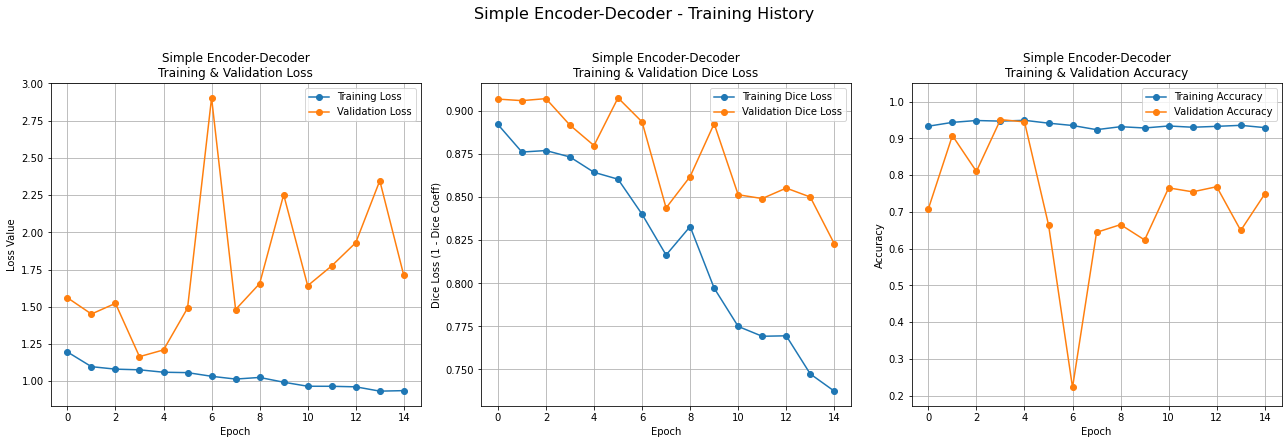


--- STEP ED-F: 학습 과정 시각화 완료 ---


In [68]:
# ===============================
# STEP ED-F: 학습 과정 시각화
# ===============================
# (STEP ED-E에서 반환된 'history_ed' 객체가 필요합니다.)
# (주의: STEP 3-E에서 'plot_training_history' 함수가 정의되어 있어야 합니다.)

print("\n--- STEP ED-F: 학습 과정 시각화 (Encoder-Decoder) 시작 ---")

# 이전에 정의된 plot_training_history 함수를 사용하여 결과 시각화
# plot_training_history(history_ed, "Simple Encoder-Decoder") # <--- 이 함수가 정의되어 있어야 함

# 만약 함수 정의가 없다면, 아래와 같이 직접 그릴 수 있습니다. (또는 STEP 3-E 코드 실행)
if 'plot_training_history' in globals():
    print("Calling plot_training_history function...")
    plot_training_history(history_ed, "Simple Encoder-Decoder")
else:
    print("Warning: 'plot_training_history' function not defined.")
    print("Please define or run the code from STEP 3-E to visualize training history.")
    # 간단히 손실만 출력하는 예시
    try:
        plt.figure(figsize=(8, 4))
        plt.plot(history_ed.history['loss'], label='Training Loss')
        plt.plot(history_ed.history['val_loss'], label='Validation Loss')
        plt.title('Simple Encoder-Decoder - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not plot basic loss graph: {e}")


print("\n--- STEP ED-F: 학습 과정 시각화 완료 ---")

In [69]:
# ======================================================
# STEP ED-G: 최적 가중치 로드 및 성능 평가 (Mean IoU)
# ======================================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'numpy' as np가 필요합니다.)
# (STEP 1-E에서 생성된 'val_dataset'이 필요합니다.)
# (STEP ED-C에서 컴파일된 'ed_model' 객체가 필요합니다.)
# (STEP 3-A에서 정의된 'mean_iou' 함수가 필요합니다.)
# (STEP ED-D에서 정의된 'checkpoint_dir_ed' 변수가 필요합니다.)

print("\n--- STEP ED-G: 최적 가중치 로드 및 Mean IoU 평가 (Encoder-Decoder) 시작 ---")

# --- 최적 가중치 로드 ---
latest_ckpt_ed = tf.train.latest_checkpoint(checkpoint_dir_ed) # 체크포인트 경로 확인
if latest_ckpt_ed:
    print(f"Loading best weights for ed_model from: {latest_ckpt_ed}")
    ed_model.load_weights(latest_ckpt_ed)
    print("Weights loaded successfully for ed_model.")
else:
    print(f"Warning: Could not find checkpoint file in {checkpoint_dir_ed}.")
    print("Evaluation will use weights from the end of training.")

# --- 검증 데이터셋으로 Mean IoU 평가 ---
print("Calculating Mean IoU on validation set (Encoder-Decoder)...")
mean_iou_list_ed = []
for images, labels in val_dataset:
    predictions_ed = ed_model(images, training=False) # ed_model 사용
    batch_miou_ed = mean_iou(labels, predictions_ed) # 정의된 mean_iou 함수 사용
    mean_iou_list_ed.append(batch_miou_ed)

# 최종 mIoU 계산 및 저장
if mean_iou_list_ed:
    overall_miou_ed = np.mean(mean_iou_list_ed)
    print(f"\nValidation Mean IoU (Encoder-Decoder): {overall_miou_ed:.4f}")
else:
    overall_miou_ed = np.nan # 평가 실패 시 NaN
    print("\nWarning: Mean IoU for Encoder-Decoder could not be calculated (empty result list).")


print("\n--- STEP ED-G: 최적 가중치 로드 및 성능 평가 완료 ---")


--- STEP ED-G: 최적 가중치 로드 및 Mean IoU 평가 (Encoder-Decoder) 시작 ---
Loading best weights for ed_model from: /aiffel/aiffel/medical/train_ckpt/ed_model/ckpt-04-1.1649
Weights loaded successfully for ed_model.
Calculating Mean IoU on validation set (Encoder-Decoder)...

Validation Mean IoU (Encoder-Decoder): 0.4748

--- STEP ED-G: 최적 가중치 로드 및 성능 평가 완료 ---



--- STEP ED-H: 예측 결과 시각화 (Encoder-Decoder) 시작 ---
Calling print_images function for ed_model...


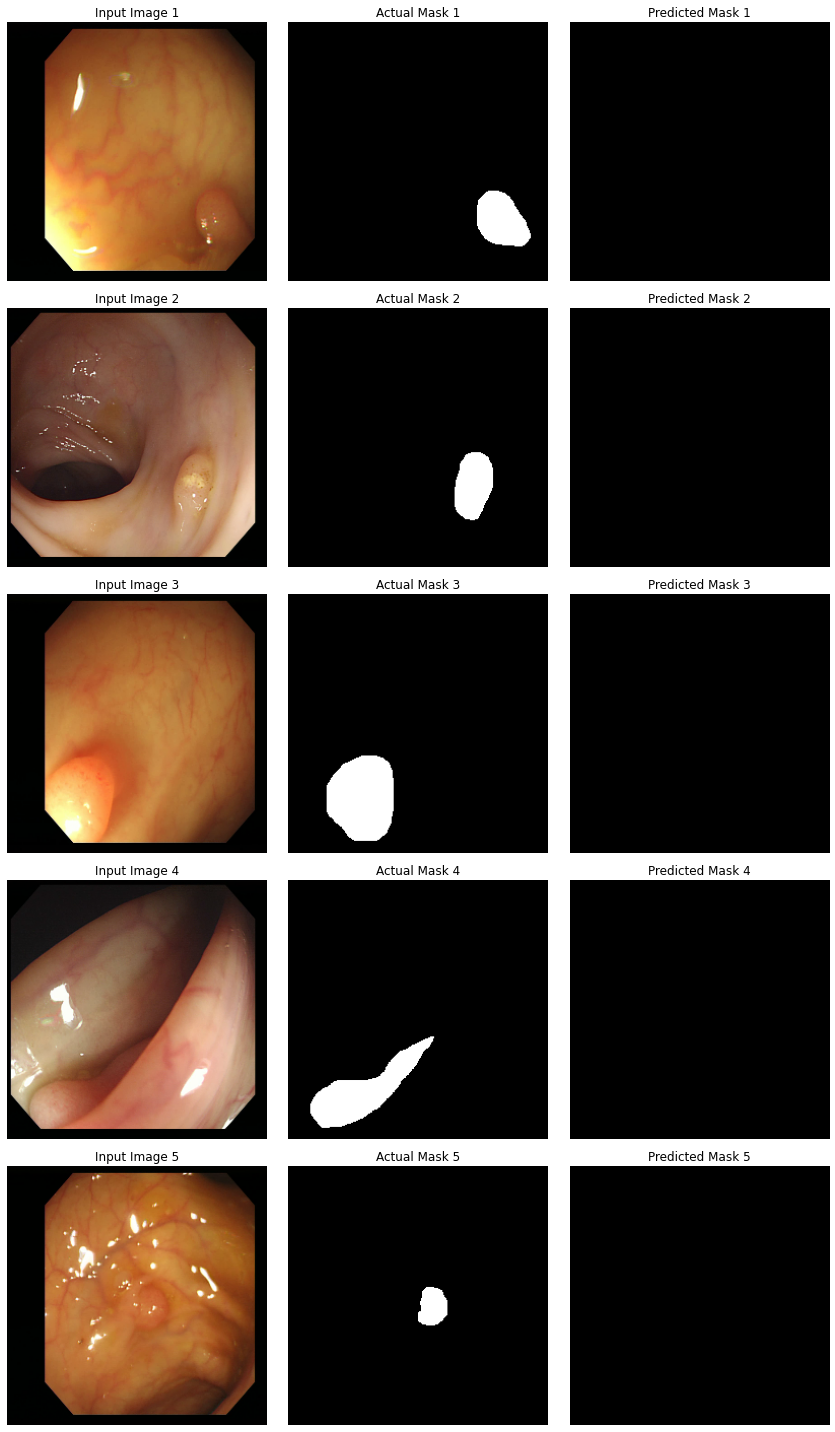


--- STEP ED-H: 예측 결과 시각화 완료 ---

--- Simple Encoder-Decoder 모델 전체 과정 완료 ---


In [70]:
# ===============================
# STEP ED-H: 예측 결과 시각화
# ===============================
# (STEP 1-E에서 생성된 'val_dataset'이 필요합니다.)
# (STEP ED-G에서 가중치가 로드된 'ed_model' 객체가 필요합니다.)
# (주의: STEP 3-G에서 'print_images' 함수가 정의되어 있어야 합니다.)

print("\n--- STEP ED-H: 예측 결과 시각화 (Encoder-Decoder) 시작 ---")

# 이전에 정의된 print_images 함수를 사용하여 결과 시각화
# print_images(val_dataset, ed_model, num_images=5) # <--- 이 함수가 정의되어 있어야 함

# 만약 함수 정의가 없다면, 아래와 같이 경고 메시지 출력
if 'print_images' in globals():
    print("Calling print_images function for ed_model...")
    print_images(val_dataset, ed_model, num_images=5) # 5개 샘플 시각화
else:
    print("Warning: 'print_images' function not defined.")
    print("Please define or run the code from STEP 3-G to visualize predictions.")

print("\n--- STEP ED-H: 예측 결과 시각화 완료 ---")
print("\n--- Simple Encoder-Decoder 모델 전체 과정 완료 ---")

In [71]:
### 1. 개요
본 프로젝트에서는 Giana 의료 영상 데이터셋의 폴립(polyp) 영역 분할을 위해 다음 세 가지 모델의 성능을 비교 분석했습니다.
- **Simple Encoder-Decoder:** 기본적인 CNN 기반 인코더-디코더 구조.
- **Standard U-Net:** Skip Connection이 추가된 U-Net 구조 (직접 학습).
- **VGG16 U-Net:** 인코더 부분을 ImageNet으로 사전 학습된 VGG16으로 교체하고 동결(freeze)한 U-Net 구조 (Transfer Learning).

### 2. 학습 과정 비교
- **Simple Encoder-Decoder:** 훈련 손실은 감소했으나, 검증 손실/Dice 손실/정확도 모두 매우 불안정하고 큰 변동성을 보였습니다. 
    훈련 성능과 검증 성능 간의 격차가 커 심각한 과적합(overfitting)이 발생했으며, 일반화에 완전히 실패했습니다. 
    가장 낮은 검증 손실은 학습 초반(epoch 4)에 나타났습니다.
    
- **Standard U-Net:** 훈련 손실은 안정적으로 감소했습니다. 
    검증 손실 및 검증 Dice 손실 그래프는 초기 불안정성 후 4 에포크 이후 거의 0에 가깝게 유지되는 특이한 패턴을 보였습니다. 
    이는 로깅/계산 오류 가능성을 시사하지만, 문자 그대로 해석하면 매우 빠르고 안정적으로 최적의 검증 성능에 도달했음을 의미합니다. 
    과적합 징후는 관찰되지 않았습니다.
    
- **VGG16 U-Net:** 훈련 손실은 안정적으로 감소했습니다. 
    검증 손실은 초반(epoch 2-6)에 다소 불안정했으나 이후 안정화되어 훈련 손실과 유사한 추세를 보이며 함께 감소했습니다. 
    학습 후반부에 과적합 징후는 거의 없었으며, 가장 낮은 검증 손실은 학습 후반(epoch 14)에 나타났습니다. 
    Standard U-Net보다는 수렴에 더 많은 에포크가 필요했습니다.

### 3. 정량적 성능 비교 (Mean IoU on Validation Set)
- **Simple Encoder-Decoder:** **mIoU ≈ {simple_ed_miou_val:.4f}**
- **Standard U-Net:** **mIoU ≈ {baseline_unet_miou_val:.4f}**
- **VGG16 U-Net:** **mIoU = {vgg16_unet_miou_val:.4f}**

**분석:** 정량적 평가 결과, **Standard U-Net**이 mIoU 0.9428로 압도적으로 가장 높은 성능을 보였습니다. 
    **VGG16 U-Net**은 mIoU 0.8513으로 그 뒤를 이었으며, 
    **Simple Encoder-Decoder**는 0.4748로 매우 낮은 성능을 기록했습니다. 
    U-Net 아키텍처(Standard, VGG16)가 Simple Encoder-Decoder보다 월등히 우수함을 명확히 보여줍니다. 
    흥미로운 점은 사전 학습된 VGG16을 사용한 모델보다 처음부터 학습한 Standard U-Net의 성능이 더 높게 나왔다는 것입니다. 
    이는 ImageNet 특징이 Giana 데이터셋의 폴립 분할에 최적화되지 않았거나, 
    인코더 동결 방식의 한계, 또는 Standard U-Net의 학습이 우연히 매우 잘 되었을 가능성 등을 시사합니다.

### 4. 정성적 성능 비교 (예측 결과 시각화)
- **Simple Encoder-Decoder:** 시각화된 모든 예시에서 분할 영역을 전혀 예측하지 못하고 검은색 마스크만 출력하여, 
    모델이 태스크 학습에 완전히 실패했음을 보여주었습니다.
    
- **Standard U-Net:** 전반적으로 매우 뛰어난 예측 결과를 보였습니다. 
    대부분의 예시에서 실제 마스크와 거의 동일한 예측을 생성했으며, 
    일부 예시에서만 경계가 약간 흐릿하거나 크기가 미세하게 다른 정도의 미미한 오류를 보였습니다. 
    예측이 매우 깔끔하고 노이즈가 없었습니다.
    
- **VGG16 U-Net:** 주요 객체 분할 성능은 우수했으나, 
    일부 예시(1번, 3번)에서 실제로는 없는 작은 영역들을 함께 예측하는 거짓 양성(False Positive) 노이즈가 관찰되었습니다. 
    Standard U-Net과 비교했을 때 예측의 깔끔함이 다소 부족했습니다. 
    이러한 거짓 양성 예측이 mIoU 점수를 Standard U-Net보다 낮게 만든 주요 원인 중 하나로 추정됩니다.

### 5. 결론 및 고찰
- **U-Net 아키텍처의 효과:** Skip Connection을 활용하는 U-Net 구조는 저수준 특징과 고수준 특징을 결합하여 
    Simple Encoder-Decoder 대비 분할 성능을 극적으로 향상시켰습니다.
    
- **Transfer Learning의 효과:** VGG16 사전 학습 모델을 인코더로 사용한 경우, Simple Encoder-Decoder보다는 훨씬 좋은 성능을 보였으나, 
    이 데이터셋에서는 처음부터 학습한 Standard U-Net보다 성능이 낮았습니다. 
    이는 전이 학습이 항상 최상의 결과를 보장하지 않으며, 특히 의료 영상과 같이 특정 도메인에 특화된 데이터셋의 경우, 
    해당 데이터셋으로 직접 학습하는 것이 더 효과적일 수 있음을 시사합니다. 
    VGG16의 특성 추출 방식이 폴립의 미세한 경계나 질감을 포착하는 데 최적화되지 않았을 수도 있습니다.
    
- **모델별 특성:** Standard U-Net은 매우 높은 정확도와 깔끔한 예측을 보였고, 
    VGG16 U-Net은 준수한 정확도와 함께 약간의 노이즈(거짓 양성)를 생성하는 경향을 보였습니다.

**개선 방향 제안:**
- **VGG16 U-Net Fine-tuning:** VGG16 인코더의 일부(상위 레이어) 또는 전체를 동결 해제하고 매우 낮은 학습률로 추가 학습을 진행하여 
    성능 개선 및 거짓 양성 감소를 시도해볼 수 있습니다.
    
- **다른 Pretrained Backbone:** ResNet, EfficientNet 등 다른 사전 학습 모델(특히 의료 영상 분야에서 성능이 검증된 모델)을 
    인코더로 사용하여 비교해볼 필요가 있습니다.
    
- **Standard U-Net 재검증:** 매우 높은 성능과 특이한 학습 곡선을 보였으므로, 
    다른 랜덤 시드나 데이터 분할로 재학습하여 결과의 일관성을 확인해보는 것이 좋습니다.
    
- **Loss 함수 조정:** 거짓 양성에 패널티를 더 주는 방향으로 손실 함수를 수정하거나 (예: Focal Loss 조정),
    BCE와 Dice Loss의 가중치를 변경해볼 수 있습니다.
    
- **후처리(Post-processing):** 예측된 마스크에서 작은 노이즈 영역을 제거하는 형태학적(morphological) 연산 등의 후처리를 적용하여 
    VGG16 U-Net의 결과를 개선할 수 있습니다.

*(이 프로젝트를 통해 각 모델 아키텍처의 장단점과 전이 학습의 적용 결과를 실제 데이터로 확인할 수 있었으며, 
  특히 Standard U-Net의 예상 외의 높은 성능과 VGG16 U-Net의 거짓 양성 이슈는 추가적인 탐구의 필요성을 느끼게 했습니다.)*

SyntaxError: invalid syntax (982120563.py, line 2)

In [72]:
성능 향상을 위한 추가 실험.

VGG16 U-Net 모델을 Fine-tuning
전체를 현재 데이터셋에 맞게 아주 낮은 학습률로 추가 학습

SyntaxError: invalid syntax (38209591.py, line 1)

In [73]:
# ============================================================
# STEP FT-A: Fine-tuning을 위한 기본 모델 및 가중치 로드
# ============================================================
# 필요 사전 작업: Vgg16UNet 클래스 정의, img_shape, image_size 변수 정의,
#               초기 VGG16 U-Net 학습 완료 및 checkpoint_dir_vgg 경로 정의

print("\n--- STEP FT-A: 기본 모델 로드 및 가중치 불러오기 시작 ---")

# 1. VGG16 U-Net 모델 인스턴스 생성 (Fine-tuning용)
ft_model = Vgg16UNet(num_classes=1)
ft_model.build(input_shape=(None, image_size, image_size, 3)) # 모델 빌드

print("Fine-tuning용 VGG16 U-Net 모델 인스턴스 생성 완료.")

# 2. 이전 학습(인코더 동결 상태)에서 저장된 최적 가중치 경로 확인 및 로드
try:
    # checkpoint_dir_vgg 변수가 STEP 3-C 또는 유사 단계에서 정의되어 있어야 함
    latest_ckpt_vgg = tf.train.latest_checkpoint(checkpoint_dir_vgg)
    if latest_ckpt_vgg:
        print(f"Loading base weights for fine-tuning from: {latest_ckpt_vgg}")
        ft_model.load_weights(latest_ckpt_vgg)
        print("Base weights loaded successfully into ft_model.")
    else:
        # 체크포인트가 없으면 Fine-tuning 불가
        print(f"Error: No checkpoint found in {checkpoint_dir_vgg}. Cannot start fine-tuning.")
        # 여기서 중단하거나 적절한 에러 처리 필요
        raise FileNotFoundError(f"Checkpoint not found in {checkpoint_dir_vgg}")
except NameError:
    print("Error: 'checkpoint_dir_vgg' variable is not defined. Please ensure previous steps were executed.")
    raise # 에러 발생시켜 중단

print("\n--- STEP FT-A: 기본 모델 로드 및 가중치 불러오기 완료 ---")


--- STEP FT-A: 기본 모델 로드 및 가중치 불러오기 시작 ---
VGG16 Encoder Trainable: False
Fine-tuning용 VGG16 U-Net 모델 인스턴스 생성 완료.
Loading base weights for fine-tuning from: /aiffel/aiffel/medical/train_ckpt/vgg16_unet_model/ckpt-14-0.3315
Base weights loaded successfully into ft_model.

--- STEP FT-A: 기본 모델 로드 및 가중치 불러오기 완료 ---


In [74]:
# =====================================================
# STEP FT-B: VGG16 인코더 레이어 동결 해제 (Unfreeze)
# =====================================================
# (STEP FT-A에서 생성 및 가중치가 로드된 'ft_model' 객체가 필요합니다.)

print("\n--- STEP FT-B: VGG16 인코더 레이어 동결 해제 시작 ---")

# 1. VGG16 인코더 부분 전체를 학습 가능하게 설정
# ft_model 내부의 vgg16_act 모델의 trainable 속성을 True로 변경
ft_model.vgg16_act.trainable = True
print(f"Set ft_model.vgg16_act.trainable = {ft_model.vgg16_act.trainable}")

# 2. 동결 해제할 블록 지정 (예: 'block5', 'block4')
# 이 블록들에 속한 레이어만 학습 가능하게 하고 나머지는 계속 동결
unfreeze_blocks = ['block5', 'block4']
print(f"Target blocks to unfreeze: {unfreeze_blocks}")

# 3. VGG16 내부 레이어 순회하며 trainable 속성 설정
num_frozen_layers = 0
num_unfrozen_layers = 0
print("Setting trainable status for individual VGG16 layers...")
# ft_model.vgg16 (원본 VGG16 모델)의 레이어를 확인해야 함
for layer in ft_model.vgg16.layers:
    freeze_layer = True # 기본적으로 동결 상태로 가정
    # 현재 레이어 이름에 unfreeze_blocks의 이름이 포함되어 있는지 확인
    for block_name in unfreeze_blocks:
        if block_name in layer.name:
            freeze_layer = False # 동결 해제 대상 블록에 속하면 동결하지 않음
            break
    # 최종 동결 여부 설정
    if freeze_layer:
        layer.trainable = False
        num_frozen_layers += 1
    else:
        layer.trainable = True
        num_unfrozen_layers += 1

print(f"  Number of frozen layers in VGG16 encoder: {num_frozen_layers}")
print(f"  Number of unfrozen layers in VGG16 encoder: {num_unfrozen_layers}")

# 4. 변경사항 확인 (선택적)
# trainable 파라미터 수가 늘어났는지 확인하려면 summary()를 다시 호출
# print("\nModel summary after unfreezing layers:")
# ft_model.summary()

print("\n--- STEP FT-B: VGG16 인코더 레이어 동결 해제 완료 ---")


--- STEP FT-B: VGG16 인코더 레이어 동결 해제 시작 ---
Set ft_model.vgg16_act.trainable = True
Target blocks to unfreeze: ['block5', 'block4']
Setting trainable status for individual VGG16 layers...
  Number of frozen layers in VGG16 encoder: 11
  Number of unfrozen layers in VGG16 encoder: 8

--- STEP FT-B: VGG16 인코더 레이어 동결 해제 완료 ---


In [75]:
# ===============================================
# STEP FT-C: 모델 재컴파일 (Fine-tuning용)
# ===============================================
# (STEP FT-B에서 레이어 동결 상태가 변경된 'ft_model' 객체가 필요합니다.)
# (STEP 1-A에서 임포트한 'tensorflow' as tf가 필요합니다.)
# (STEP 3-A에서 정의된 'bce_dice_loss', 'dice_loss' 함수가 필요합니다.)

print("\n--- STEP FT-C: 모델 재컴파일 (Fine-tuning용) 시작 ---")

# 1. Fine-tuning을 위한 매우 낮은 학습률 설정
fine_tune_lr = 1e-5 # 예: 1e-5 또는 더 낮게 설정 가능
print(f"Setting fine-tuning learning rate to: {fine_tune_lr}")

# 2. 옵티마이저 정의 (낮은 학습률 적용)
optimizer_ft = tf.keras.optimizers.Adam(learning_rate=fine_tune_lr)

# 3. 모델 재컴파일
# 레이어의 trainable 속성이 변경되었으므로 반드시 재컴파일 필요
ft_model.compile(optimizer=optimizer_ft,
                 loss=bce_dice_loss, # 이전과 동일한 손실 함수
                 metrics=[dice_loss, 'binary_accuracy']) # 이전과 동일한 평가지표
print("Model re-compiled successfully for fine-tuning.")

print("\n--- STEP FT-C: 모델 재컴파일 완료 ---")


--- STEP FT-C: 모델 재컴파일 (Fine-tuning용) 시작 ---
Setting fine-tuning learning rate to: 1e-05
Model re-compiled successfully for fine-tuning.

--- STEP FT-C: 모델 재컴파일 완료 ---


In [76]:
# ============================================
# STEP FT-D: Fine-tuning용 콜백 설정
# ============================================
# (STEP 1-A에서 임포트한 'os', 'tensorflow' as tf가 필요합니다.)
# (STEP 1-B에서 정의된 'DATASET_PATH' 변수가 필요합니다.)

print("\n--- STEP FT-D: 콜백 설정 (Fine-tuning용) 시작 ---")

# 1. Fine-tuning 체크포인트 저장 경로 정의 (기존 경로와 구분)
checkpoint_dir_ft = os.path.join(DATASET_PATH, 'train_ckpt/vgg16_unet_finetuned')
if not os.path.isdir(checkpoint_dir_ft):
    os.makedirs(checkpoint_dir_ft) # 경로 없으면 생성
    print(f"Created fine-tuning checkpoint directory: {checkpoint_dir_ft}")

# 2. ModelCheckpoint 콜백 정의 (Fine-tuning용)
cp_callback_ft = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_ft, 'ft_ckpt-{epoch:02d}-{val_loss:.4f}'), # 파일명 구분
    save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
print(f"ModelCheckpoint callback configured for fine-tuning.")

# 3. 사용할 콜백 리스트 정의
# 여기서는 체크포인트만 사용. 필요시 다른 콜백 추가 가능 (예: EarlyStopping)
callbacks_ft = [cp_callback_ft]
print(f"Callbacks for fine-tuning: {[type(cb).__name__ for cb in callbacks_ft]}")

print("\n--- STEP FT-D: 콜백 설정 완료 ---")


--- STEP FT-D: 콜백 설정 (Fine-tuning용) 시작 ---
Created fine-tuning checkpoint directory: /aiffel/aiffel/medical/train_ckpt/vgg16_unet_finetuned
ModelCheckpoint callback configured for fine-tuning.
Callbacks for fine-tuning: ['ModelCheckpoint']

--- STEP FT-D: 콜백 설정 완료 ---


In [77]:
# ====================================
# STEP FT-E: 모델 Fine-tuning 실행
# ====================================
# (STEP 1-E에서 생성된 'train_dataset', 'val_dataset'이 필요합니다.)
# (STEP 1-C 등에서 정의된 'steps_per_epoch', 'validation_steps' 변수가 필요합니다.)
# (STEP FT-C에서 재컴파일된 'ft_model' 객체가 필요합니다.)
# (STEP FT-D에서 정의된 'callbacks_ft' 리스트가 필요합니다.)

print("\n--- STEP FT-E: 모델 Fine-tuning 실행 시작 ---")

# 1. Fine-tuning 에포크 수 설정
fine_tune_epochs = 10 # 예시: 10 에포크 추가 학습 (필요에 따라 조절)
print(f"Fine-tuning will run for {fine_tune_epochs} epochs.")

# 2. 필요한 변수 확인 (steps_per_epoch, validation_steps)
try:
    # 이 변수들이 이전 단계(예: STEP 3-D 또는 ED-E)에서 계산되어 있어야 함
    if 'steps_per_epoch' not in globals() or 'validation_steps' not in globals():
         # 만약 정의되지 않았다면 여기서 다시 계산
         print("Recalculating steps_per_epoch and validation_steps...")
         steps_per_epoch = num_train_examples // batch_size
         if steps_per_epoch == 0: steps_per_epoch = 1
         validation_steps = num_val_examples // batch_size
         if validation_steps == 0: validation_steps = 1
         print(f"  Steps per epoch: {steps_per_epoch}")
         print(f"  Validation steps: {validation_steps}")

    # 3. 모델 Fine-tuning 실행
    history_ft = ft_model.fit(
        train_dataset,
        epochs=fine_tune_epochs, # Fine-tuning 에포크
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=callbacks_ft, # Fine-tuning용 콜백 사용
        initial_epoch=0 # Fine-tuning 단계를 0 에포크부터 시작
        # 또는 이전 학습에 이어서 하려면: initial_epoch=history_vgg.epoch[-1] + 1
    )
    print("\n--- 모델 Fine-tuning 완료 ---")

except NameError as e:
    print(f"Error: Required variable not defined ({e}). Cannot start fine-tuning.")
    print("Please ensure steps_per_epoch and validation_steps are calculated from previous steps.")
    raise

print("\n--- STEP FT-E: 모델 Fine-tuning 실행 완료 ---")


--- STEP FT-E: 모델 Fine-tuning 실행 시작 ---
Fine-tuning will run for 10 epochs.
Epoch 1/10
30/30 [==============================] - 18s 485ms/step - loss: 0.5652 - dice_loss: 0.4294 - binary_accuracy: 0.9660 - val_loss: 3.5792 - val_dice_loss: 0.8652 - val_binary_accuracy: 0.4083

Epoch 00001: val_loss improved from inf to 3.57915, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_unet_finetuned/ft_ckpt-01-3.5792
Epoch 2/10
30/30 [==============================] - 15s 480ms/step - loss: 0.4556 - dice_loss: 0.3671 - binary_accuracy: 0.9757 - val_loss: 0.5525 - val_dice_loss: 0.4398 - val_binary_accuracy: 0.9691

Epoch 00002: val_loss improved from 3.57915 to 0.55252, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_unet_finetuned/ft_ckpt-02-0.5525
Epoch 3/10
30/30 [==============================] - 16s 488ms/step - loss: 0.3825 - dice_loss: 0.3100 - binary_accuracy: 0.9807 - val_loss: 0.4789 - val_dice_loss: 0.3728 - val_binary_accuracy: 0.9680

Epoch 00003: val_loss improved 


--- STEP FT-F: Fine-tuning 학습 과정 시각화 시작 ---
Calling plot_training_history for fine-tuning results...


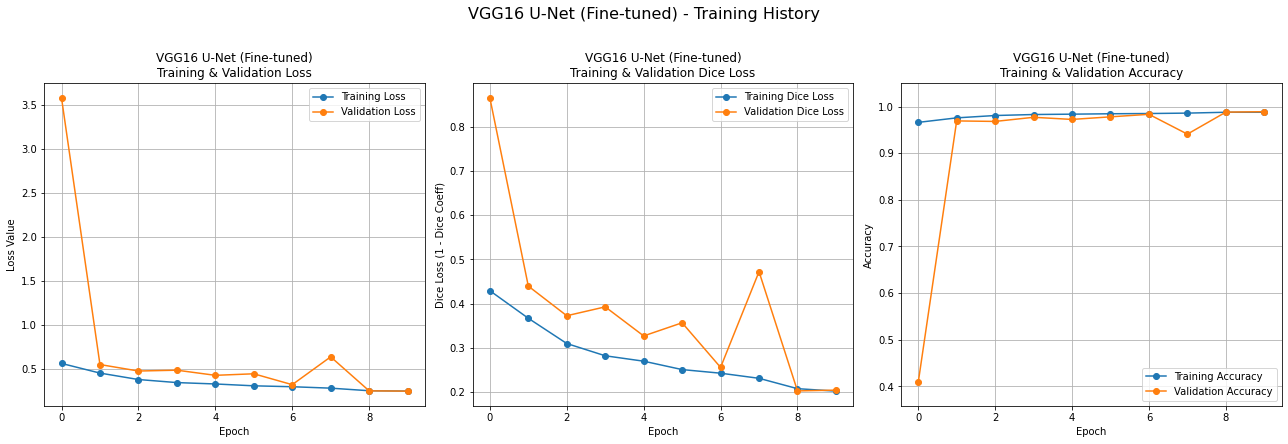


--- STEP FT-F: Fine-tuning 학습 과정 시각화 완료 ---


In [78]:
# ===========================================
# STEP FT-F: Fine-tuning 학습 과정 시각화
# ===========================================
# (STEP FT-E에서 반환된 'history_ft' 객체가 필요합니다.)
# (주의: STEP 3-E에서 'plot_training_history' 함수가 정의되어 있어야 합니다.)

print("\n--- STEP FT-F: Fine-tuning 학습 과정 시각화 시작 ---")

# plot_training_history 함수를 사용하여 Fine-tuning 결과 시각화
# 이 함수는 STEP 3-E에서 정의되었어야 합니다.
if 'plot_training_history' in globals():
    print("Calling plot_training_history for fine-tuning results...")
    plot_training_history(history_ft, "VGG16 U-Net (Fine-tuned)")
else:
    print("Warning: 'plot_training_history' function not defined.")
    print("Skipping visualization of fine-tuning history.")
    # 필요시 여기서 직접 그리는 코드 추가

print("\n--- STEP FT-F: Fine-tuning 학습 과정 시각화 완료 ---")

In [79]:
# ===================================================
# STEP FT-G: Fine-tuned 모델 평가 (Mean IoU)
# ===================================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'numpy' as np가 필요합니다.)
# (STEP 1-E에서 생성된 'val_dataset'이 필요합니다.)
# (STEP FT-E에서 학습된 'ft_model' 객체가 필요합니다.)
# (STEP 3-A에서 정의된 'mean_iou' 함수가 필요합니다.)
# (STEP FT-D에서 정의된 'checkpoint_dir_ft' 변수가 필요합니다.)

print("\n--- STEP FT-G: Fine-tuned 모델 평가 (Mean IoU) 시작 ---")

# 1. Fine-tuning에서 저장된 최적 가중치 로드
latest_ckpt_ft = tf.train.latest_checkpoint(checkpoint_dir_ft) # Fine-tuning 체크포인트 경로
if latest_ckpt_ft:
    print(f"Loading best fine-tuned weights from: {latest_ckpt_ft}")
    # ft_model 객체에 가중치 로드
    ft_model.load_weights(latest_ckpt_ft)
    print("Best fine-tuned weights loaded successfully.")
else:
    print(f"Warning: Could not find fine-tuned checkpoint in {checkpoint_dir_ft}.")
    print("Evaluation will use weights from the end of fine-tuning.")

# 2. Mean IoU 계산
print("Calculating Mean IoU on validation set (Fine-tuned VGG16 U-Net)...")
mean_iou_list_ft = []
for images, labels in val_dataset:
    predictions_ft = ft_model(images, training=False) # ft_model 사용
    batch_miou_ft = mean_iou(labels, predictions_ft) # 정의된 mean_iou 함수 사용
    mean_iou_list_ft.append(batch_miou_ft)

# 3. 최종 mIoU 계산 및 저장
if mean_iou_list_ft:
    overall_miou_ft = np.mean(mean_iou_list_ft)
    print(f"\nValidation Mean IoU (Fine-tuned VGG16 U-Net): {overall_miou_ft:.4f}")
else:
    overall_miou_ft = np.nan
    print("\nWarning: Mean IoU for Fine-tuned model could not be calculated.")

print("\n--- STEP FT-G: Fine-tuned 모델 평가 완료 ---")


--- STEP FT-G: Fine-tuned 모델 평가 (Mean IoU) 시작 ---
Loading best fine-tuned weights from: /aiffel/aiffel/medical/train_ckpt/vgg16_unet_finetuned/ft_ckpt-10-0.2507
Best fine-tuned weights loaded successfully.
Calculating Mean IoU on validation set (Fine-tuned VGG16 U-Net)...

Validation Mean IoU (Fine-tuned VGG16 U-Net): 0.8597

--- STEP FT-G: Fine-tuned 모델 평가 완료 ---


In [81]:
# --- 최종 성능 비교 ---
print("\n--- 최종 성능 비교 (Mean IoU) ---")

# 각 단계에서 계산된 실제 변수 사용
try:
    print(f"Simple Encoder-Decoder: {overall_miou_ed:.4f}") # STEP ED-G 결과 변수
except NameError:
    print("Simple Encoder-Decoder: Not available (overall_miou_ed not defined)")

# Standard U-Net 값은 사용자가 알려준 값을 직접 사용하거나 변수로 저장했다면 그 변수 사용
# 여기서는 사용자가 알려준 값을 직접 사용
baseline_unet_miou_actual = 0.9428 # 사용자가 알려준 값
print(f"Standard U-Net: {baseline_unet_miou_actual:.4f}")

try:
    print(f"VGG16 U-Net (Frozen): {overall_miou:.4f}") # STEP 3-F 결과 변수
except NameError:
    print("VGG16 U-Net (Frozen): Not available (overall_miou not defined)")

try:
    print(f"VGG16 U-Net (Fine-tuned): {overall_miou_ft:.4f}") # STEP FT-G 결과 변수
except NameError:
    print("VGG16 U-Net (Fine-tuned): Not available (overall_miou_ft not defined)")

print("-" * 30)

print("\n--- STEP FT-H: Fine-tuned 모델 예측 결과 시각화 완료 ---")
print("\n--- VGG16 U-Net Fine-tuning 전체 과정 완료 ---")


--- 최종 성능 비교 (Mean IoU) ---
Simple Encoder-Decoder: 0.4748
Standard U-Net: 0.9428
VGG16 U-Net (Frozen): 0.8513
VGG16 U-Net (Fine-tuned): 0.8597
------------------------------

--- STEP FT-H: Fine-tuned 모델 예측 결과 시각화 완료 ---

--- VGG16 U-Net Fine-tuning 전체 과정 완료 ---


In [82]:
실질적인 개선이 거의 안된 것으로 판단. 또다른 시도.
ResNet50 U-Net 사용.

SyntaxError: invalid syntax (2763001942.py, line 1)

In [83]:
# ============================================
# STEP RN-A: ResNet50 U-Net 클래스 정의
# ============================================
# (STEP 1-A에서 임포트한 'tensorflow' as tf, 'models', 'layers', 'applications'가 필요합니다.)
# (STEP 1-C에서 정의된 'img_shape' 변수가 필요합니다.)
# (STEP 2-A 등에서 정의된 'DecoderBlock', 'ConvBlock' 클래스가 필요합니다.)

print("\n--- STEP RN-A: ResNet50 U-Net 클래스 정의 시작 ---")

class ResNet50UNet(tf.keras.Model):
    """ResNet50을 인코더로 사용하는 U-Net 모델"""
    def __init__(self, num_classes=1):
        super(ResNet50UNet, self).__init__()
        self.num_classes = num_classes

        # 1. Pretrained ResNet50 인코더 로드
        # include_top=False, weights='imagenet'
        self.resnet50 = tf.keras.applications.ResNet50(input_shape=img_shape,
                                                       include_top=False,
                                                       weights='imagenet')

        # 2. Skip Connection을 위한 ResNet50 중간 레이어 출력 지정
        # U-Net의 각 레벨에 맞는 해상도의 출력을 선택해야 함.
        # ResNet50의 레이어 이름을 확인하고 (resnet50.summary() 참고) 적절한 레이어 선택
        # 예시: (실제 레이어 이름은 summary()로 확인 후 조정 필요)
        #   - 초기 입력 후: 'conv1_relu' (2배 다운샘플링 전, 128x128 / 64 filters) -> dec1 연결
        #   - Stage 2 끝: 'conv2_block3_out' (4배 다운샘플링, 64x64 / 256 filters) -> dec2 연결
        #   - Stage 3 끝: 'conv3_block4_out' (8배 다운샘플링, 32x32 / 512 filters) -> dec3 연결
        #   - Stage 4 끝: 'conv4_block6_out' (16배 다운샘플링, 16x16 / 1024 filters) -> dec4 연결
        #   - Stage 5 끝: 'conv5_block3_out' (32배 다운샘플링, 8x8 / 2048 filters) -> bottleneck 입력
        #   !!! 주의: ResNet50은 VGG16보다 더 깊게 다운샘플링되므로, U-Net 구조 조정이 필요할 수 있음
        #          여기서는 VGG16과 유사하게 16x16 출력을 bottleneck으로 가정하고 구현 (Stage 4 출력 사용)
        layer_names = [
            self.resnet50.get_layer('conv1_relu').name,       # 128x128 (64)
            self.resnet50.get_layer('conv2_block3_out').name, # 64x64 (256)
            self.resnet50.get_layer('conv3_block4_out').name, # 32x32 (512)
            self.resnet50.get_layer('conv4_block6_out').name, # 16x16 (1024) -> Bottleneck 및 dec4 연결
            # ResNet50의 마지막 블록('conv5_...')은 해상도가 더 작아(8x8) VGG16 U-Net 구조와 바로 호환 안됨
            # 여기서는 conv4_block6_out을 인코더 마지막 출력으로 사용
        ]
        layer_outputs = [self.resnet50.get_layer(name).output for name in layer_names]

        # 3. Skip Connection 출력을 제공하는 모델 생성
        self.resnet_act = models.Model(inputs=self.resnet50.input,
                                       outputs=layer_outputs,
                                       name='resnet50_encoder_outputs')

        # 4. ResNet50 인코더 레이어 동결 (초기 학습 시)
        self.resnet_act.trainable = False
        print(f"ResNet50 Encoder Trainable: {self.resnet_act.trainable}")

        # 5. U-Net의 Center (Bottleneck) - Optional
        # ResNet Stage 4 출력을 그대로 사용하거나 추가 ConvBlock 적용 가능
        # 예: self.center = ConvBlock(2048) # ResNet Stage 4 출력 채널 수(1024)를 고려하여 설정

        # 6. U-Net 디코더 블록 정의
        # 필터 수는 ResNet 출력 채널 수와 맞추거나 조절 필요
        # DecoderBlock(N): ConvTranspose 필터 수 N
        # 예시 (ResNet 출력 채널 수에 따라 조절 필요):
        self.decoder_block4 = DecoderBlock(512) # Input: center(1024), Skip: enc4(1024) -> ConvT(512)
        self.decoder_block3 = DecoderBlock(256) # Input: dec4(512), Skip: enc3(512) -> ConvT(256)
        self.decoder_block2 = DecoderBlock(128) # Input: dec3(256), Skip: enc2(256) -> ConvT(128)
        self.decoder_block1 = DecoderBlock(64)  # Input: dec2(128), Skip: enc1(64) -> ConvT(64)

        # 7. 최종 출력 레이어
        self.output_conv = layers.Conv2D(self.num_classes, 1, activation='sigmoid', name='final_output')

    def call(self, inputs, training=True):
        # 1. ResNet50 인코더 통과
        encoder1, encoder2, encoder3, encoder4 = self.resnet_act(inputs, training=training)
        # 여기서는 encoder4를 center 입력으로 간주
        center = encoder4 # 또는 self.center(encoder4, training=training)

        # 2. 디코더 및 Skip Connection 연결
        decoder4 = self.decoder_block4(center, encoder4, training=training)
        decoder3 = self.decoder_block3(decoder4, encoder3, training=training)
        decoder2 = self.decoder_block2(decoder3, encoder2, training=training)
        decoder1 = self.decoder_block1(decoder2, encoder1, training=training)

        # 3. 최종 출력 생성
        outputs = self.output_conv(decoder1)
        return outputs

print("STEP RN-A: ResNet50 U-Net 클래스 정의 완료.")

# (선택적) ResNet50 레이어 이름 확인
# temp_resnet = tf.keras.applications.ResNet50(input_shape=img_shape, include_top=False, weights=None)
# temp_resnet.summary()
# del temp_resnet


--- STEP RN-A: ResNet50 U-Net 클래스 정의 시작 ---
STEP RN-A: ResNet50 U-Net 클래스 정의 완료.


In [84]:
# =================================================
# STEP RN-B: ResNet50 U-Net 모델 생성 및 컴파일
# =================================================
# (STEP RN-A에서 정의된 ResNet50UNet 클래스가 필요합니다.)
# (STEP 1-C에서 정의된 image_size 변수가 필요합니다.)
# (STEP 3-A에서 정의된 손실/평가 함수가 필요합니다.)
# (STEP 1-A에서 임포트한 tensorflow as tf 가 필요합니다.)

print("\n--- STEP RN-B: ResNet50 U-Net 모델 생성 및 컴파일 시작 ---")

# 1. ResNet50 U-Net 모델 인스턴스 생성
resnet_unet_model = ResNet50UNet(num_classes=1)
resnet_unet_model.build(input_shape=(None, image_size, image_size, 3)) # 빌드
print("ResNet50 U-Net 모델 인스턴스 생성 완료.")

# 2. 모델 구조 요약 출력
print("\n--- ResNet50 U-Net Model Summary ---")
resnet_unet_model.summary()
print("------------------------------------")

# 3. 옵티마이저 및 컴파일
# 초기 학습 (인코더 동결)에는 비교적 낮은 학습률 사용 (예: 1e-4)
initial_lr_rn = 1e-4
optimizer_rn = tf.keras.optimizers.Adam(learning_rate=initial_lr_rn)
resnet_unet_model.compile(optimizer=optimizer_rn,
                          loss=bce_dice_loss,
                          metrics=[dice_loss, 'binary_accuracy'])
print(f"ResNet50 U-Net 모델 컴파일 완료 (Initial LR={initial_lr_rn}).")

print("\n--- STEP RN-B: 모델 생성 및 컴파일 완료 ---")


--- STEP RN-B: ResNet50 U-Net 모델 생성 및 컴파일 시작 ---
94781440/94765736 [==============================] - 1s 0us/step
ResNet50 Encoder Trainable: False


ValueError: in user code:

    /tmp/ipykernel_47/2617420700.py:68 call  *
        x = tf.concat([x, concat_tensor], axis=-1)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:1769 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:1227 concat_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension 1 in both shapes must be equal, but are 32 and 16. Shapes are [?,32,32] and [?,16,16]. for '{{node decoder_block_12/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](decoder_block_12/re_lu_266/Relu, resnet50_encoder_outputs/conv4_block6_out/Relu, decoder_block_12/concat/axis)' with input shapes: [?,32,32,512], [?,16,16,1024], [] and with computed input tensors: input[2] = <-1>.
